In [116]:
import sys
sys.path.append("..")

In [118]:
import os

# prevent JAX from preallocating all GPU memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# data loading
import pandas as pd
import numpy as np

# plotting
#import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

# pyro
import numpyro
import numpyro.distributions as dist
from numpyro.infer import Predictive
from numpyro.handlers import condition, trace
from numpyro.contrib.control_flow import scan, cond

numpyro.set_host_device_count(4)

# jax
import jax
import jax.numpy as jnp
import jax.random as random

if any([d.platform == "gpu" for d in jax.devices()]):
    numpyro.set_platform("gpu")

from jax.lib import xla_bridge
print(f"current XLA device: {xla_bridge.get_backend().platform}")

import weathergen as wx
import wxsbi

current XLA device: cpu


In [120]:
# enable autoreload of source files
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

In [122]:
name_map = wx.data.data_var_name_map(prec="pr", Tair_mean="tavg", Tair_min="tmin", Tair_max="tmax", time = "date")
basin_data_all = wx.data.load_time_series_csv("../data/potsdam.csv", name_map)

# Choose training period
basin_data_train = basin_data_all["1950":"1999"]

# Remove two datapoints where Tmin == Tavg
basin_data_train = basin_data_train.drop(index=basin_data_train.iloc[[6579, 6994], :].index)

In [6]:
assert np.all(basin_data_train["Tair_min"] < basin_data_train["Tair_mean"])
assert np.all(basin_data_train["Tair_min"] < basin_data_train["Tair_max"])
assert np.all(basin_data_train["Tair_mean"] < basin_data_train["Tair_max"])
assert np.all(basin_data_train["prec"] >= 0)

# Model

In [11]:
from weathergen.wgen.wgen_gamlss import *

In [12]:
#wgen = wx.WGEN(basin_data_train, model = wx.wgen_glm_v2, order = 2, Tair_freqs=Tair_freqs, prec_freqs=prec_freqs)
#wgen = wx.WGEN(basin_data_train, order = 2, Tair_freqs=Tair_freqs, prec_freqs=prec_freqs)
wgen = wx.WGEN(basin_data_train, model = WGEN_GAMLSS(), order = 2, Tair_freqs=[1/365.25, 2/365.25], prec_freqs=[1/365.25, 2/365.25])

Run variational inference for parameter estimates:

In [13]:
from numpyro.infer import SVI, TraceGraph_ELBO
from numpyro.infer.autoguide import AutoDelta, AutoNormal, AutoMultivariateNormal

num_iter = 50_000
prng = random.PRNGKey(1234)
guide = AutoMultivariateNormal(wgen.step, init_loc_fn=numpyro.infer.init_to_median)
#guide = AutoNormal(wgen.step, init_loc_fn=numpyro.infer.init_to_median)

svi_result = wgen.fit(num_iter, guide, subsample_time=1000, rng=prng)

100%|██████████| 50000/50000 [04:02<00:00, 205.78it/s, init loss: 841246.1875, avg. loss [47501-50000]: 44065.1065]


Get posterior samples:

In [15]:
posterior_sampler = Predictive(guide, params=svi_result.params, num_samples=100)
posterior_params = posterior_sampler(prng)
{k: v.mean(axis=0) for k,v in posterior_params.items() if k != "_auto_latent"}

{'Tavg_loc_lag': Array([-0.14882793,  0.91425765], dtype=float32),
 'Tavg_loc_pred': Array([2.3666542], dtype=float32),
 'Tavg_loc_scale_pred': Array([0.79412365], dtype=float32),
 'Tavg_loc_scale_seasonal': Array([ 0.07795422, -0.04347372,  0.04786297,  0.07800472], dtype=float32),
 'Tavg_loc_seasonal': Array([-0.69216543,  0.10522281, -2.6576083 ,  0.15666878], dtype=float32),
 'Tavg_loc_seasonal_lag_interaction': Array([-0.01195042,  0.02712371, -0.00594028,  0.00157948,  0.04121456,
        -0.01662296,  0.05997713,  0.00340156], dtype=float32),
 'Trange_disp_lag': Array([0.01467347, 0.10206976], dtype=float32),
 'Trange_disp_lag_seasonal_interaction': Array([-0.03774556, -0.03983821,  0.09992593, -0.01632523, -0.01676272,
         0.03891807, -0.02205569, -0.03242754], dtype=float32),
 'Trange_disp_pred': Array([-0.25020412], dtype=float32),
 'Trange_disp_seasonal': Array([ 0.05211044, -0.00671545,  0.06343778, -0.23653182], dtype=float32),
 'Trange_mean_Tavg': Array([0.6132945], 

Get predictive distributions and run simulations

In [17]:
svi_predictive = Predictive(wgen.simulate, posterior_samples=posterior_params, parallel=True)
svi_preds = svi_predictive(prng)

In [13]:
obs = wgen.obs

In [14]:
from weathergen.plotting import *

In [15]:
obs["Tmin"] = obs["Tavg"] - obs["Trange"] * obs["Tskew"]
obs["Tmax"] = obs["Tmin"] + obs["Trange"]

## Model diagnostics

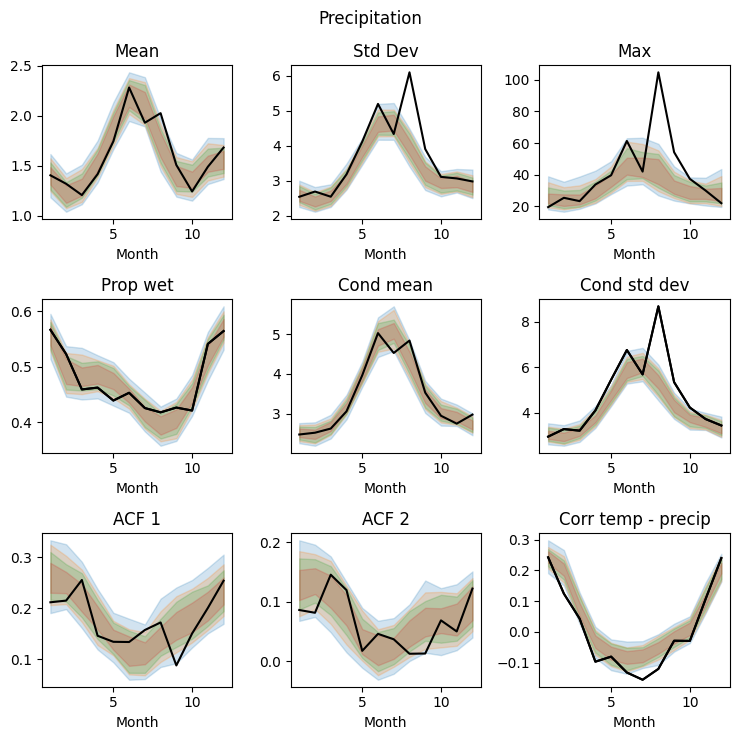

In [116]:
fig = plt.figure(layout="tight", figsize=(7.5, 7.5))
fig.suptitle("Precipitation")

gs = GridSpec(3, 3, figure=fig)

# Row 1
ax_row_1 = [fig.add_subplot(gs[0, i]) for i in range(3)]
get_mean_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_1[0])
get_std_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_1[1])
get_max_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_1[2])

# Row 2
ax_row_2 = [fig.add_subplot(gs[1, i]) for i in range(3)]
get_prop_wet_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_2[0])
get_cond_mean_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_2[1])
get_cond_std_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_2[2])

# Row 3
ax_row_3 = [fig.add_subplot(gs[2, i]) for i in range(3)]
get_acf_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_3[0], lag=1)
get_acf_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_3[1], lag=2)
get_temp_precip_cor_plot(obs["Tavg"], svi_preds["Tavg"], obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_3[2])


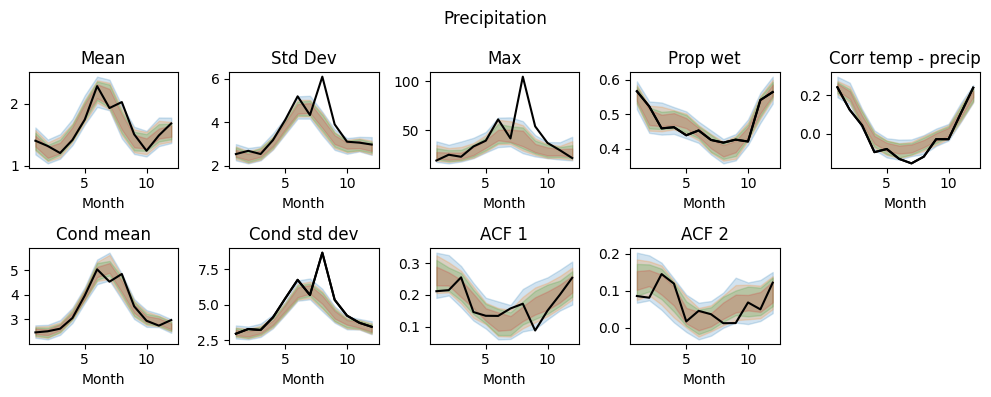

In [117]:
fig = plt.figure(layout="tight", figsize=(10, 4))
fig.suptitle("Precipitation")

gs = GridSpec(2, 5, figure=fig)

# Row 1
ax_row_1 = [fig.add_subplot(gs[0, i]) for i in range(5)]
get_mean_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_1[0])
get_std_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_1[1])
get_max_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_1[2])
get_prop_wet_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_1[3])
get_temp_precip_cor_plot(obs["Tavg"], svi_preds["Tavg"], obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_1[4])



# Row 2
ax_row_2 = [fig.add_subplot(gs[1, i]) for i in range(5)]
get_cond_mean_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_2[0])
get_cond_std_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_2[1])
get_acf_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_2[2], lag=1)
get_acf_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_2[3], lag=2)
ax_row_2[4].axis("off")

plt.savefig("plots/pr_paper.png", dpi = 300)

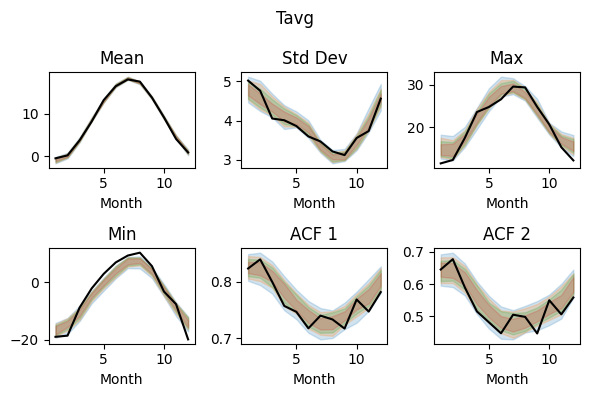

In [118]:
fig = plt.figure(layout="tight", figsize=(6, 4))
fig.suptitle("Tavg")

gs = GridSpec(2, 3, figure=fig)

# Row 1
ax_row_1 = [fig.add_subplot(gs[0, i]) for i in range(3)]
get_mean_plot(obs["Tavg"], svi_preds["Tavg"], basin_data_train.index, ax=ax_row_1[0])
get_std_plot(obs["Tavg"], svi_preds["Tavg"], basin_data_train.index, ax=ax_row_1[1])
get_max_plot(obs["Tavg"], svi_preds["Tavg"], basin_data_train.index, ax=ax_row_1[2])

# Row 2
ax_row_2 = [fig.add_subplot(gs[1, i]) for i in range(3)]
get_min_plot(obs["Tavg"], svi_preds["Tavg"], basin_data_train.index, ax=ax_row_2[0])
get_acf_plot(obs["Tavg"], svi_preds["Tavg"], basin_data_train.index, ax=ax_row_2[1], lag=1)
get_acf_plot(obs["Tavg"], svi_preds["Tavg"], basin_data_train.index, ax=ax_row_2[2], lag=2)

plt.savefig("plots/tavg_paper.png", dpi = 300)

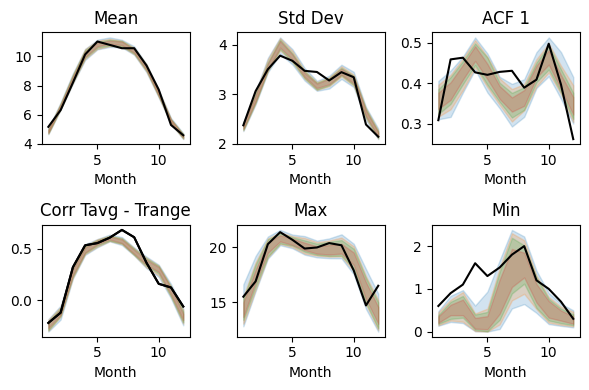

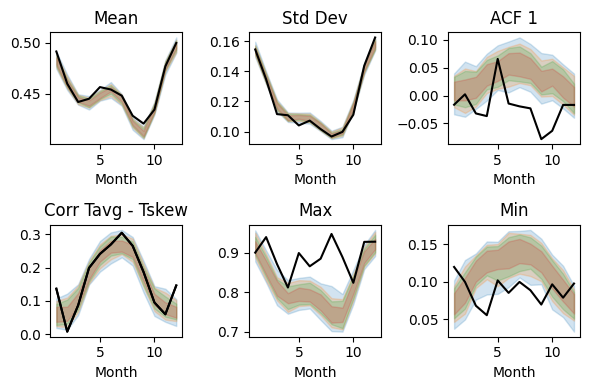

In [119]:
fig = plt.figure(layout="tight", figsize=(6, 4))
#fig.suptitle("Trange")

gs = GridSpec(2, 3, figure=fig)

# Row 1
ax_row_1 = [fig.add_subplot(gs[0, i]) for i in range(3)]
get_mean_plot(obs["Trange"], svi_preds["Trange"], basin_data_train.index, ax=ax_row_1[0])
get_std_plot(obs["Trange"], svi_preds["Trange"], basin_data_train.index, ax=ax_row_1[1])
get_acf_plot(obs["Trange"], svi_preds["Trange"], basin_data_train.index, ax=ax_row_1[2], lag=1)

ax_row_2 = [fig.add_subplot(gs[1, i]) for i in range(3)]
get_cor_plot(obs["Tavg"], svi_preds["Tavg"], obs["Trange"], svi_preds["Trange"], basin_data_train.index,  "Tavg", "Trange", ax=ax_row_2[0])
#get_acf_plot(obs["Trange"], svi_preds["Trange"], basin_data_train.index, ax=ax_row_2[0], lag=2)
get_max_plot(obs["Trange"], svi_preds["Trange"], basin_data_train.index, ax=ax_row_2[1])
get_min_plot(obs["Trange"], svi_preds["Trange"], basin_data_train.index, ax=ax_row_2[2])

plt.savefig("plots/trange_paper.png", dpi = 300)


fig = plt.figure(layout="tight", figsize=(6, 4))
#fig.suptitle("Tskew")
gs = GridSpec(2, 3, figure=fig)

# Row 1
ax_row_1 = [fig.add_subplot(gs[0, i]) for i in range(3)]
get_mean_plot(obs["Tskew"], svi_preds["Tskew"], basin_data_train.index, ax=ax_row_1[0])
get_std_plot(obs["Tskew"], svi_preds["Tskew"], basin_data_train.index, ax=ax_row_1[1])
get_acf_plot(obs["Tskew"], svi_preds["Tskew"], basin_data_train.index, ax=ax_row_1[2], lag=1)

ax_row_2 = [fig.add_subplot(gs[1, i]) for i in range(3)]
get_cor_plot(obs["Tavg"], svi_preds["Tavg"], obs["Tskew"], svi_preds["Tskew"], basin_data_train.index, "Tavg", "Tskew", ax=ax_row_2[0])
#get_acf_plot(obs["Tskew"], svi_preds["Tskew"], basin_data_train.index, ax=ax_row_2[0], lag=2)
get_max_plot(obs["Tskew"], svi_preds["Tskew"], basin_data_train.index, ax=ax_row_2[1])
get_min_plot(obs["Tskew"], svi_preds["Tskew"], basin_data_train.index, ax=ax_row_2[2])

plt.savefig("plots/tskew_paper.png", dpi = 300)

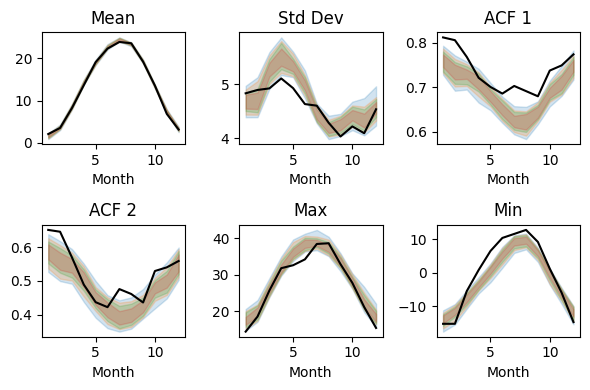

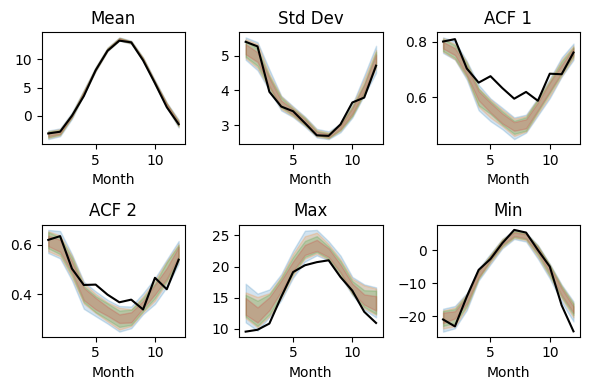

In [120]:
fig = plt.figure(layout="tight", figsize=(6, 4))
#fig.suptitle("Tmax")

gs = GridSpec(2, 3, figure=fig)

# Row 1
ax_row_1 = [fig.add_subplot(gs[0, i]) for i in range(3)]
get_mean_plot(obs["Tmax"], svi_preds["Tmax"], basin_data_train.index, ax=ax_row_1[0])
get_std_plot(obs["Tmax"], svi_preds["Tmax"], basin_data_train.index, ax=ax_row_1[1])
get_acf_plot(obs["Tmax"], svi_preds["Tmax"], basin_data_train.index, ax=ax_row_1[2], lag=1)

ax_row_2 = [fig.add_subplot(gs[1, i]) for i in range(3)]
get_acf_plot(obs["Tmax"], svi_preds["Tmax"], basin_data_train.index, ax=ax_row_2[0], lag=2)
get_max_plot(obs["Tmax"], svi_preds["Tmax"], basin_data_train.index, ax=ax_row_2[1])
get_min_plot(obs["Tmax"], svi_preds["Tmax"], basin_data_train.index, ax=ax_row_2[2])

plt.savefig("plots/tmax_paper.png", dpi = 300)


fig = plt.figure(layout="tight", figsize=(6, 4))
#fig.suptitle("Tmin")
gs = GridSpec(2, 3, figure=fig)

# Row 1
ax_row_1 = [fig.add_subplot(gs[0, i]) for i in range(3)]
get_mean_plot(obs["Tmin"], svi_preds["Tmin"], basin_data_train.index, ax=ax_row_1[0])
get_std_plot(obs["Tmin"], svi_preds["Tmin"], basin_data_train.index, ax=ax_row_1[1])
get_acf_plot(obs["Tmin"], svi_preds["Tmin"], basin_data_train.index, ax=ax_row_1[2], lag=1)

ax_row_2 = [fig.add_subplot(gs[1, i]) for i in range(3)]
get_acf_plot(obs["Tmin"], svi_preds["Tmin"], basin_data_train.index, ax=ax_row_2[0], lag=2)
get_max_plot(obs["Tmin"], svi_preds["Tmin"], basin_data_train.index, ax=ax_row_2[1])
get_min_plot(obs["Tmin"], svi_preds["Tmin"], basin_data_train.index, ax=ax_row_2[2])

plt.savefig("plots/tmin_paper.png", dpi = 300)

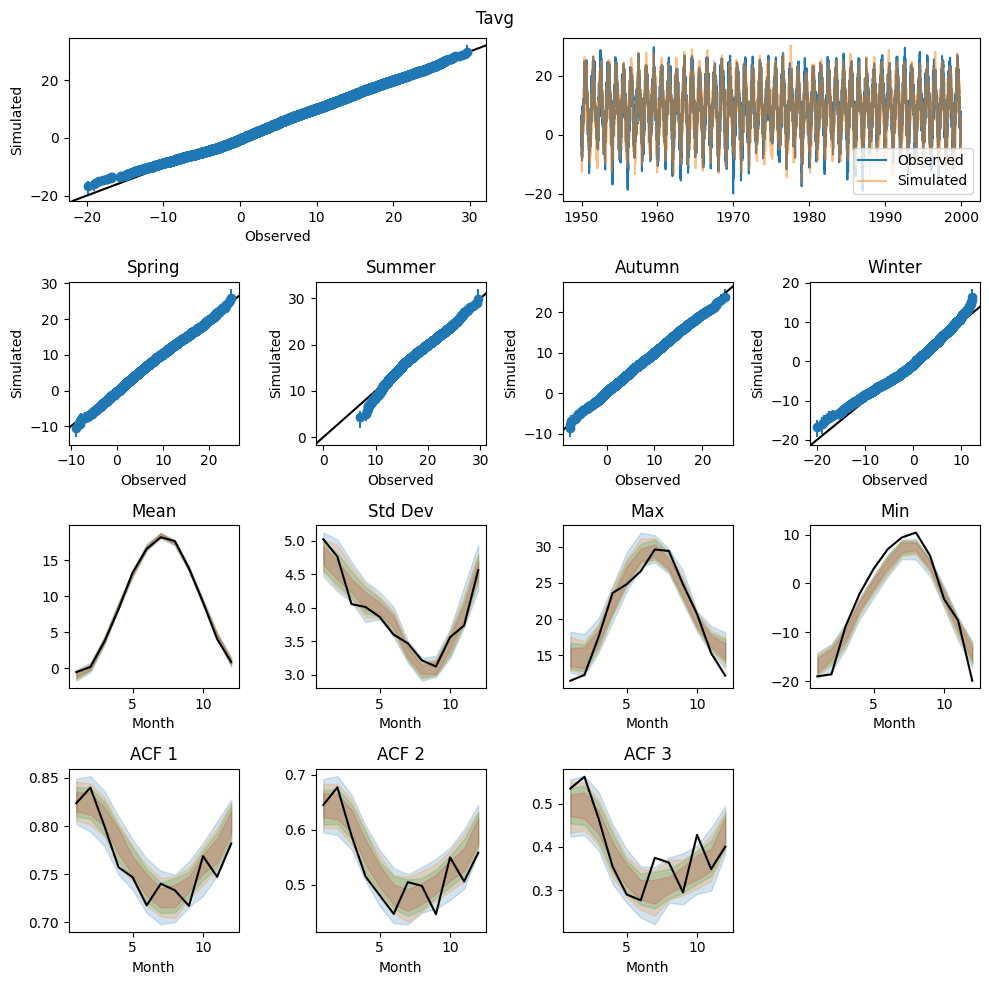

In [121]:
Tavg_overview(obs, svi_preds, basin_data_train)
plt.savefig("plots/wgen_Tavg.png")

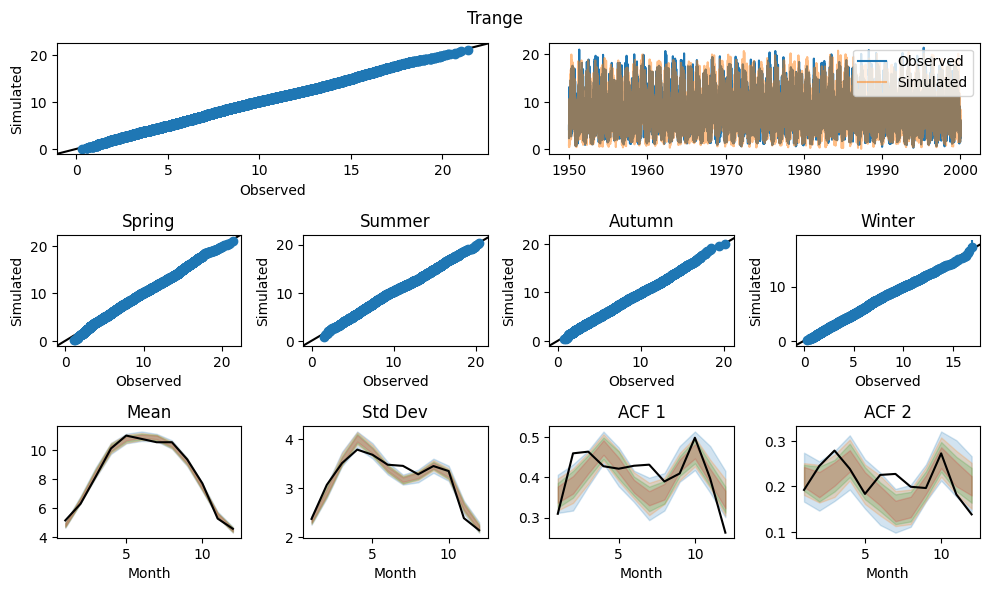

In [122]:
Trange_overview(obs, svi_preds, basin_data_train)
plt.savefig("plots/wgen_Trange.png")

In [123]:
Tskew_overview(obs, svi_preds, basin_data_train)
plt.savefig("plots/wgen_Tskew.png")

In [35]:
Tmin_overview(obs, svi_preds, basin_data_train)
plt.savefig("plots/wgen_Tmin.png")

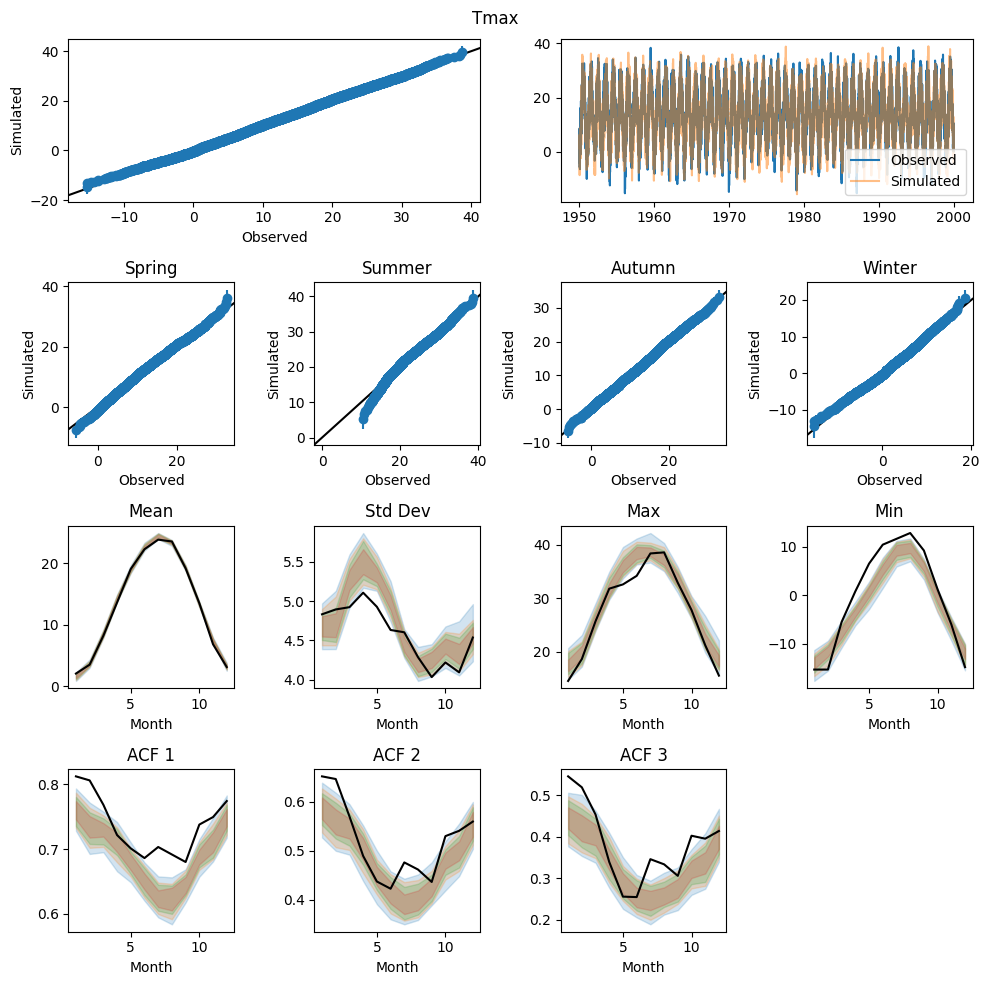

In [36]:
Tmax_overview(obs, svi_preds, basin_data_train)
plt.savefig("plots/wgen_Tmax.png")

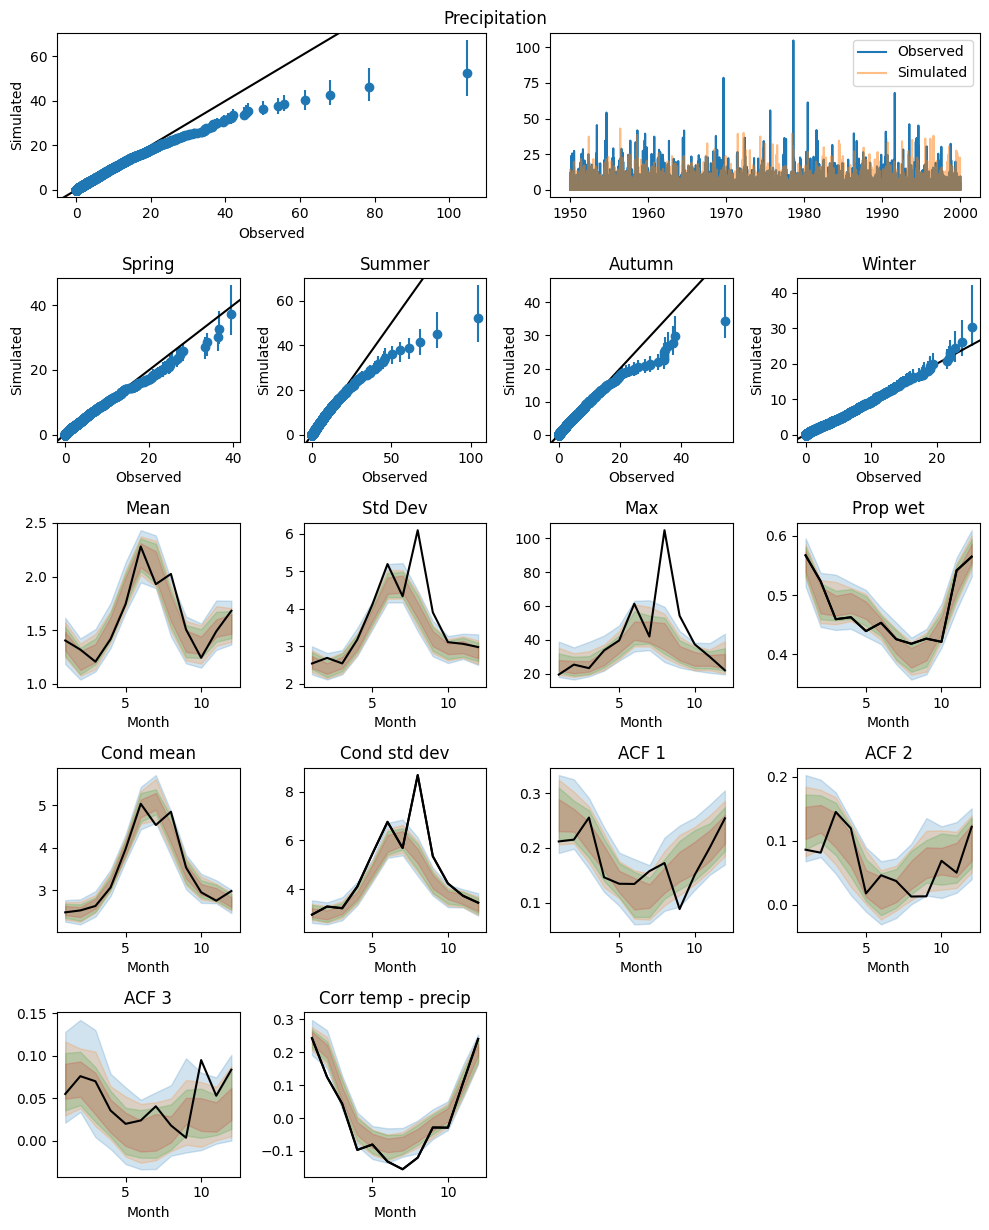

In [37]:
prec_overview(obs, svi_preds, basin_data_train)
plt.savefig("plots/wgen_prec.png")

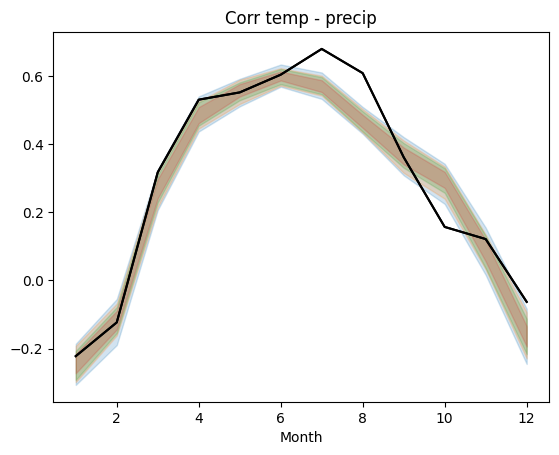

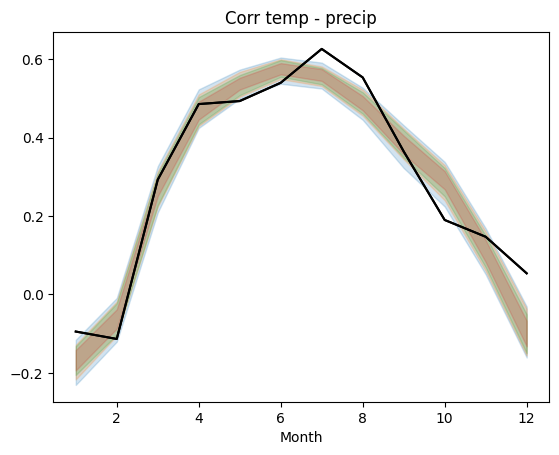

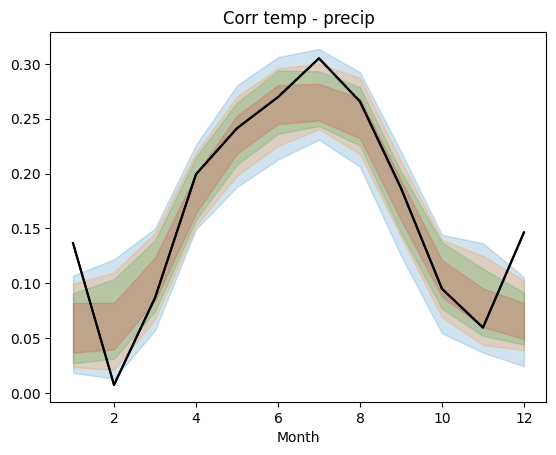

In [38]:
get_temp_precip_cor_plot(obs["Tavg"], svi_preds["Tavg"], obs["Trange"], svi_preds["Trange"], basin_data_train.index)

get_temp_precip_cor_plot(obs["Tavg"], svi_preds["Tavg"], obs["Trange"]*obs["Tskew"], svi_preds["Trange"]*svi_preds["Tskew"], basin_data_train.index)

get_temp_precip_cor_plot(obs["Tavg"], svi_preds["Tavg"], obs["Tskew"], svi_preds["Tskew"], basin_data_train.index)

# SBI

In [60]:
import torch
from jax2torch.jax2torch import jax2torch, j2t, t2j
from sbi.inference import SNPE, SNLE, simulate_for_sbi
from sbi.utils.user_input_checks import process_prior, process_simulator

torch.manual_seed(1234)

In [130]:
def run_sbi(wgen, svi_result, observable_fct, obs_target, scale_factor = 2.5, parameter_mask = None, num_samples = 2000, num_rounds = 10):
    """
    Run SBI on a weather generator to calibrate it to a set of target statistics.

    Args:
        wgen: A WGEN object including a weather generator.
        svi_result: The result of an SVI fit through wgen.fit.
        observable_fct: A function taking as input arrays of realizations of ts, precip, Tmin, Tavg, Tmax and outputting summary statistics.
        obs_target: A vector of target summary statistics.
        scale_factor: Scaling amount for the posterior to obtain the SBI prior.
        parameter_mask: A mask to keep certain parameters from being scaled up. Helps with the SBI fit.
        
    Returns:
        tuple[array,array | None]: outputs, observable

    """
    sim, sim_prior = wgen.simulator(observable=observable_fct, rng_seed=1234) # Generate simulator and prior
    wgen_sbi = jax2torch(sim) # Convert to torch for sbi

    print("Sampling...")

    fitted_posterior = guide.get_posterior(svi_result.params)

    # Sample from mean of fitted posterior
    summary_stats_samples_from_mean_fitted_posterior = wgen_sbi(j2t(fitted_posterior.mean).unsqueeze(0).expand(num_samples, -1))

    # Sample from fitted posterior
    proposal_fitted_posterior = torch.distributions.MultivariateNormal(j2t(fitted_posterior.mean), j2t(fitted_posterior.covariance_matrix))
    samples_from_fitted_posterior = proposal_fitted_posterior.sample((num_samples,))
    summary_stats_samples_from_fitted_posterior = wgen_sbi(samples_from_fitted_posterior)

    # Sample from scaled up posterior (proposal for SBI)
    if parameter_mask is None:
        parameter_mask = 1.
    sbi_proposal = torch.distributions.MultivariateNormal(j2t(fitted_posterior.mean), j2t(jnp.diag(fitted_posterior.covariance_matrix)*jnp.eye(len(fitted_posterior.mean)) + parameter_mask*(scale_factor**2 - 1)*jnp.eye(len(fitted_posterior.mean))* jnp.diag(fitted_posterior.covariance_matrix)))
    samples_from_sbi_proposal = sbi_proposal.sample((num_samples,))
    summary_stats_samples_from_sbi_proposal = wgen_sbi(samples_from_sbi_proposal)

    # Plot fitted posterior and SBI proposal as well as targets
    fig, axs = plt.subplots(1, obs_target.shape[0], figsize = (obs_target.shape[0]*5, 5))
    for i in range(obs_stats.shape[0]):
        axs[i].hist(summary_stats_samples_from_fitted_posterior[:, i].numpy(), bins = 20, density = True, alpha = 0.5, label = "Fitted posterior")
        axs[i].hist(summary_stats_samples_from_sbi_proposal[:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "Climatology matching prior")
        axs[i].legend(loc = "upper right")
        axs[i].axvline(obs_target[i,:].flatten(), c= "black")
    plt.show()

    print("Running SBI...")

    # Run SBIne
    sbi_alg = SNPE(sbi_proposal)
    num_simulations = 1000
    proposal = sbi_proposal
    for i in range(num_rounds):
        theta, x = simulate_for_sbi(wgen_sbi, proposal=proposal, num_simulations=num_simulations, simulation_batch_size=500)
        sbi_alg.append_simulations(theta, x, proposal, exclude_invalid_x=True)
        density_estimator = sbi_alg.train()
        sbi_posterior = sbi_alg.build_posterior(density_estimator).set_default_x(j2t(obs_target.squeeze()))
        proposal = sbi_posterior

    print("Sampling Climatology matching posterior and point estimate...")

    # Sample from Climatology matching posterior
    samples_from_sbi_posterior = sbi_posterior.sample((num_samples,))
    summary_stats_samples_from_sbi_posterior = wgen_sbi(samples_from_sbi_posterior)

    # Plot
    fig, axs = plt.subplots(1, obs_target.shape[0], figsize = (obs_target.shape[0]*5, 5))
    for i in range(obs_stats.shape[0]):
        axs[i].hist(summary_stats_samples_from_fitted_posterior[:, i].numpy(), bins = 20, density = True, alpha = 0.5, label = "Fitted posterior")
        axs[i].hist(summary_stats_samples_from_sbi_proposal[:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "Climatology matching prior")
        axs[i].hist(summary_stats_samples_from_sbi_posterior[:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "Climatology matching posterior")
        axs[i].legend(loc = "upper right")
        axs[i].axvline(obs_target[i,:].flatten(), c= "black")
    plt.show()

    # Get point estimate
    map_estimate = sbi_posterior.map()

    # Dict to return
    samples_summary_stats = {
        "mean_fitted_posterior": summary_stats_samples_from_mean_fitted_posterior,
        "fitted_posterior": summary_stats_samples_from_fitted_posterior, 
        "sbi_proposal": summary_stats_samples_from_sbi_proposal,
        "sbi_posterior": summary_stats_samples_from_sbi_posterior,
        "sbi_posterior_point_estimate": wgen_sbi(map_estimate.expand(num_samples, -1))
    }

    # Get realizations from weather generator
    simulator_get_obs, _ = wgen.simulator(rng_seed=1234)
    simulator_get_obs = jax2torch(simulator_get_obs)
    
    samples_obs = {
        "mean_fitted_posterior": simulator_get_obs(j2t(fitted_posterior.mean).unsqueeze(0).expand(100, -1)),
        "fitted_posterior": simulator_get_obs(proposal_fitted_posterior.sample((100,))),
        "sbi_posterior": simulator_get_obs(sbi_posterior.sample((100,))),
        "sbi_posterior_point_estimate": simulator_get_obs(map_estimate.expand(100, -1))
    }

    return sbi_posterior, samples_summary_stats, samples_obs


def check_if_list_in_string(l, x):
    for elem in l:
        if elem in x:
            return True
    return False
    
def get_parameter_mask(guide, ignore_elems):
    return jnp.concat([jnp.zeros_like(x) if check_if_list_in_string(ignore_elems, k) else jnp.ones_like(x) for k, x in guide._init_locs.items()])


In [131]:
import pickle
import os.path

def save_sbi_case_study(case_study, sbi_posterior, samples_summary_stats, samples_obs, analysis = "analysis_v9"):
    with open(os.path.join("sbi_results", analysis, f"case_study_{case_study}_sbi_posterior.pkl"), "wb") as handle:
        pickle.dump(sbi_posterior, handle)
    torch.save(samples_summary_stats, os.path.join("sbi_results", analysis, f"case_study_{case_study}_samples_summary_stats.pt"))
    torch.save(samples_obs, os.path.join("sbi_results", analysis, f"case_study_{case_study}_samples_summary_obs.pt"))


In [30]:
# Get parameter mask of parameters to ignore
posterior_sampler = Predictive(guide, params=svi_result.params, num_samples=100)
posterior_params = posterior_sampler(prng)


## Case study 1a (Tavg, pr, dry days const.):

Trend in tavg, precip, dry days constant:

In [125]:
num_rounds = 5

In [126]:
def case_study_1a(ts, precip, Tmin, Tavg, Tmax):
    pmean = jnp.mean(precip, axis = 0)
    pavgwet = jnp.mean(precip > 0, axis = 0)
    Tavgmean = jnp.mean(Tavg, axis = 0)
    return jnp.stack([pmean, pavgwet, Tavgmean])

In [37]:
obs['Tmin'] = obs['Tavg'] - obs['Tskew']*obs['Trange']
obs['Tmax'] = obs['Tmin'] + obs['Trange']
obs_stats = case_study_1a(wgen.timestamps[0,:,:], obs['prec'].T, obs['Tmin'].T, obs['Tavg'].T, obs['Tmax'].T)
obs_stats

Array([[1.6045674],
       [0.4748631],
       [8.81644  ]], dtype=float32)

In [38]:
obs_stats_target = obs_stats
obs_stats_target = obs_stats_target.at[0].mul(1.2)
obs_stats_target = obs_stats_target.at[2].add(3.5)
obs_stats_target

Array([[ 1.925481 ],
       [ 0.4748631],
       [12.31644  ]], dtype=float32)

Sampling...


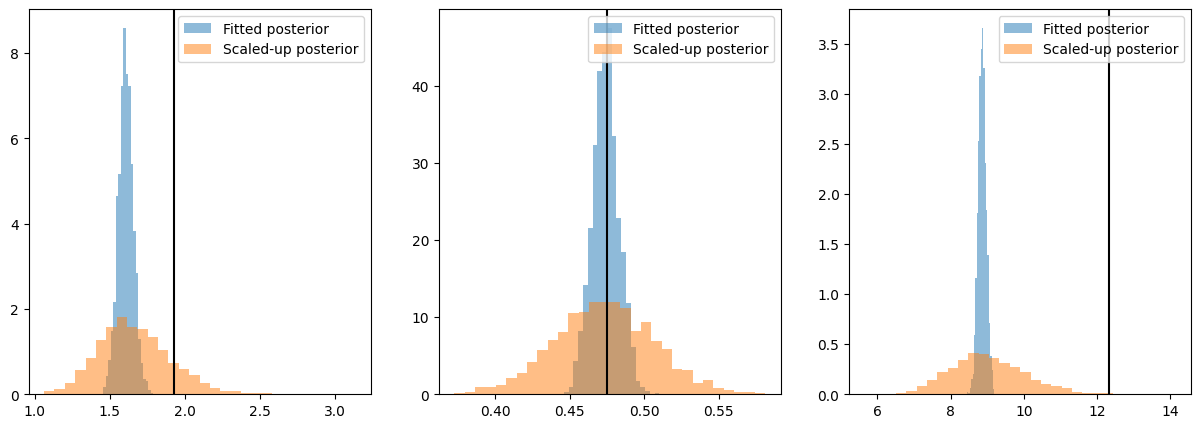

Running SBI...


Running 1000 simulations.: 100%|██████████| 1000/1000 [02:08<00:00,  7.77it/s]


 Neural network successfully converged after 52 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:02<00:00,  8.15it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 70 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:00<00:00,  8.32it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 68 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:00<00:00,  8.33it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 47 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:24<00:00,  6.94it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 27 epochs.Sampling SBI posterior and point estimate...


Drawing 2000 posterior samples: 100%|██████████| 2000/2000 [00:03<00:00, 654.95it/s]


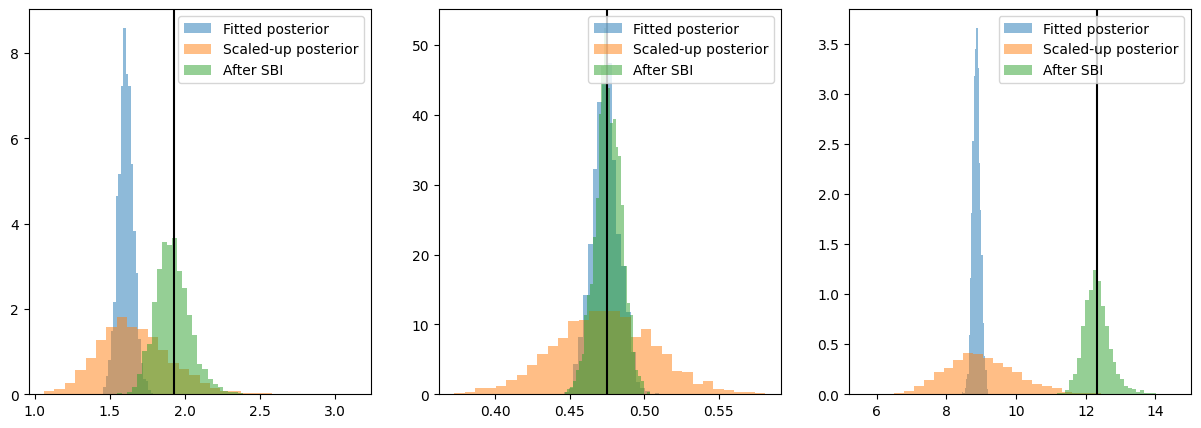

Drawing 100 posterior samples: 100%|██████████| 100/100 [00:00<00:00, 178.71it/s]


In [39]:
parameter_mask = get_parameter_mask(guide, ["Trange", "Tskew", "precip_occ_"])
sbi_posterior, samples_summary_stats, samples_obs = run_sbi(wgen, svi_result, observable_fct = case_study_1a, obs_target = obs_stats_target, scale_factor = 2., parameter_mask = parameter_mask, num_samples = 2000, num_rounds = num_rounds)
save_sbi_case_study("1a", sbi_posterior, samples_summary_stats, samples_obs, analysis = "analysis_v9")

## Case study 1b (as 1a but dry day prior scaled up, not included in paper):

Trend in tavg, precip, dry days constant:

In [41]:
num_rounds = 5

In [78]:
def case_study_1b(ts, precip, Tmin, Tavg, Tmax):
    pmean = jnp.mean(precip, axis = 0)
    pavgwet = jnp.mean(precip > 0, axis = 0)
    Tavgmean = jnp.mean(Tavg, axis = 0)
    return jnp.stack([pmean, pavgwet, Tavgmean])

In [58]:
obs['Tmin'] = obs['Tavg'] - obs['Tskew']*obs['Trange']
obs['Tmax'] = obs['Tmin'] + obs['Trange']
obs_stats = case_study_1b(wgen.timestamps[0,:,:], obs['prec'].T, obs['Tmin'].T, obs['Tavg'].T, obs['Tmax'].T)
obs_stats

Array([[1.6045674],
       [0.4748631],
       [8.81644  ]], dtype=float32)

In [59]:
obs_stats_target = obs_stats
obs_stats_target = obs_stats_target.at[0].mul(1.2)
obs_stats_target = obs_stats_target.at[2].add(3.5)
obs_stats_target

Array([[ 1.925481 ],
       [ 0.4748631],
       [12.31644  ]], dtype=float32)

In [60]:
parameter_mask = get_parameter_mask(guide, ["Trange", "Tskew"])
sbi_posterior, samples_summary_stats, samples_obs = run_sbi(wgen, svi_result, observable_fct = case_study_1b, obs_target = obs_stats_target, scale_factor = 2., parameter_mask = parameter_mask, num_samples = 2000, num_rounds = num_rounds)
save_sbi_case_study("1b", sbi_posterior, samples_summary_stats, samples_obs, analysis = "analysis_v9")

Sampling...


Running SBI...


Running 1000 simulations.: 100%|██████████| 1000/1000 [02:00<00:00,  8.31it/s]


 Neural network successfully converged after 52 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:57<00:00,  8.55it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 70 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:04<00:00,  8.05it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 45 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:05<00:00,  7.97it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 35 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:03<00:00,  8.09it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 39 epochs.Sampling SBI posterior and point estimate...


Drawing 2000 posterior samples: 100%|██████████| 2000/2000 [00:02<00:00, 722.05it/s]


Drawing 100 posterior samples: 100%|██████████| 100/100 [00:00<00:00, 178.06it/s]


## Case study 2 (Tavg, pr, heavy rain, icy days, tropical night, Trange)

Note: $\gamma = 3.5$ here to make sure prior closer to target in statistic nr. 5 (tropical nights).

In [28]:
num_rounds = 10

In [30]:
def case_study_2(ts, precip, Tmin, Tavg, Tmax):
    """
    ts: [1, timesteps, 4], 4: index, year, month, doy
    precip, Tmin, Tavg, Tmax: [timesteps, realizations]
    Returns: [summary_stats, realizations]
    """

    Tavgmean = jnp.mean(Tavg, axis = 0)
    
    pmean = jnp.mean(precip, axis = 0)
    heavy_rain = jnp.mean(precip > 20, axis = 0)

    icy_days = jnp.mean(Tmax < 0, axis = 0)
    tropical_nights = jnp.mean(Tmin > 20, axis = 0)

    Trangemean = jnp.mean(Tmax - Tmin, axis = 0)

    return jnp.stack([Tavgmean, pmean, heavy_rain, icy_days, tropical_nights, Trangemean])

obs['Tmin'] = obs['Tavg'] - obs['Tskew']*obs['Trange']
obs['Tmax'] = obs['Tmin'] + obs['Trange']
obs_stats = case_study_2(jnp.expand_dims(wgen.timestamps[0,:,:], 0), obs['prec'].T, obs['Tmin'].T, obs['Tavg'].T, obs['Tmax'].T)
obs_stats

Array([[8.8164396e+00],
       [1.6045674e+00],
       [7.2289160e-03],
       [6.6538885e-02],
       [8.2146772e-04],
       [8.3253994e+00]], dtype=float32)

In [40]:
obs_stats_target = obs_stats
obs_stats_target = obs_stats_target.at[0].add(3.1) # Tavg 
obs_stats_target = obs_stats_target.at[1].mul(1.3) # pmean 
obs_stats_target = obs_stats_target.at[2].mul(2.) # heavy_rain
obs_stats_target = obs_stats_target.at[3].set(0.01) # icy_days: 3 per year
obs_stats_target = obs_stats_target.at[4].set(0.08) # tropical_nights: 30 per year
obs_stats_target = obs_stats_target.at[5].mul(1.2) # Trangemean

obs_stats_target

Array([[1.1916439e+01],
       [2.0859375e+00],
       [1.4457832e-02],
       [9.9999998e-03],
       [7.9999998e-02],
       [9.9904795e+00]], dtype=float32)

Run SBI:

In [44]:
parameter_mask = None# get_parameter_mask(guide, ["seasonal"])
sbi_posterior, samples_summary_stats, samples_obs = run_sbi(wgen, svi_result, observable_fct = case_study_2, obs_target = obs_stats_target, scale_factor = 3.5, parameter_mask = parameter_mask, num_samples = 2000, num_rounds = num_rounds)
save_sbi_case_study("temp_2", sbi_posterior, samples_summary_stats, samples_obs, analysis = "analysis_v9")

Sampling...


Running SBI...


Running 1000 simulations.: 100%|██████████| 1000/1000 [04:58<00:00,  3.35it/s]


 Neural network successfully converged after 59 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [04:06<00:00,  4.06it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 83 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [03:57<00:00,  4.21it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 48 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [03:48<00:00,  4.38it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 57 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [03:51<00:00,  4.33it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 28 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [03:08<00:00,  5.31it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 42 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [03:46<00:00,  4.42it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 34 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [03:31<00:00,  4.72it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [03:35<00:00,  4.63it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 42 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:56<00:00,  5.68it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 26 epochs.Sampling Climatology matching posterior and point estimate...


Drawing 2000 posterior samples: 100%|██████████| 2000/2000 [00:03<00:00, 619.06it/s]


Drawing 100 posterior samples: 100%|██████████| 100/100 [00:00<00:00, 152.78it/s]


## Case study 3a (seasonal Tavg, pr, monthly dry days const)

In [32]:
num_rounds = 10

In [34]:
def case_study_3a(ts, precip, Tmin, Tavg, Tmax):
    """
    ts: [1, timesteps, 4], 4: index, year, month, doy
    precip, Tmin, Tavg, Tmax: [timesteps, realizations]
    Returns: [summary_stats, realizations]
    """
    winter = jnp.isin(ts[:, :, 2], jnp.array([12, 1, 2])).T
    spring = jnp.isin(ts[:, :, 2], jnp.array([3, 4, 5])).T
    summer = jnp.isin(ts[:, :, 2], jnp.array([6, 7, 8])).T
    autumn = jnp.isin(ts[:, :, 2], jnp.array([9, 10, 11])).T

    pmean_winter = jnp.nanmean(jnp.where(winter, precip, jnp.nan), axis = 0)
    pmean_spring = jnp.nanmean(jnp.where(spring, precip, jnp.nan), axis = 0)
    pmean_summer = jnp.nanmean(jnp.where(summer, precip, jnp.nan), axis = 0)
    pmean_autumn = jnp.nanmean(jnp.where(autumn, precip, jnp.nan), axis = 0)

    wet = (precip > 0)
    
    monthly_pavg_wet = []
    for i in range(1, 13):
        month = (ts[:, :, 2] == i).T
        pavgwet_month = jnp.nanmean(jnp.where(month, wet, jnp.nan), axis = 0)
        monthly_pavg_wet.append(pavgwet_month)
    
    Tavg_winter = jnp.nanmean(jnp.where(winter, Tavg, jnp.nan), axis = 0)
    Tavg_spring = jnp.nanmean(jnp.where(spring, Tavg, jnp.nan), axis = 0)
    Tavg_summer = jnp.nanmean(jnp.where(summer, Tavg, jnp.nan), axis = 0)
    Tavg_autumn = jnp.nanmean(jnp.where(autumn, Tavg, jnp.nan), axis = 0)

    #icy_days = jnp.mean(Tmax < 0, axis = 0)
    #heavy_rain = jnp.mean(precip > 20, axis = 0)

    return jnp.stack([pmean_winter, pmean_spring, pmean_summer, pmean_autumn, Tavg_winter, Tavg_spring, Tavg_summer, Tavg_autumn, *monthly_pavg_wet])#, icy_days])

obs['Tmin'] = obs['Tavg'] - obs['Tskew']*obs['Trange']
obs['Tmax'] = obs['Tmin'] + obs['Trange']
obs_stats = case_study_3a(jnp.expand_dims(wgen.timestamps[0,:,:], 0), obs['prec'].T, obs['Tmin'].T, obs['Tavg'].T, obs['Tmax'].T)
obs_stats

Array([[ 1.4723725 ],
       [ 1.4552826 ],
       [ 2.075413  ],
       [ 1.4105054 ],
       [ 0.17860311],
       [ 8.408174  ],
       [17.475306  ],
       [ 9.037077  ],
       [ 0.5668173 ],
       [ 0.5230333 ],
       [ 0.45935485],
       [ 0.46266666],
       [ 0.43935484],
       [ 0.45333335],
       [ 0.42580646],
       [ 0.4180645 ],
       [ 0.42666668],
       [ 0.4212903 ],
       [ 0.5413333 ],
       [ 0.5645161 ]], dtype=float32)

In [34]:
obs_stats_target = obs_stats
obs_stats_target = obs_stats_target.at[0].mul(1.3) # pmean winter
obs_stats_target = obs_stats_target.at[1].mul(1.3) # pmean spring
obs_stats_target = obs_stats_target.at[2].mul(1.) # pmean summer
obs_stats_target = obs_stats_target.at[3].mul(1.15) # pmean autumn

obs_stats_target = obs_stats_target.at[4].add(3.4) # Tavg winter
obs_stats_target = obs_stats_target.at[5].add(2.6) # Tavg spring
obs_stats_target = obs_stats_target.at[6].add(3.1) # Tavg summer
obs_stats_target = obs_stats_target.at[7].add(4.5) # Tavg autumn

obs_stats_target

Array([[ 1.9140842 ],
       [ 1.8918673 ],
       [ 2.075413  ],
       [ 1.6220812 ],
       [ 3.5786033 ],
       [11.008173  ],
       [20.575306  ],
       [13.537077  ],
       [ 0.5668173 ],
       [ 0.5230333 ],
       [ 0.45935485],
       [ 0.46266666],
       [ 0.43935484],
       [ 0.45333335],
       [ 0.42580646],
       [ 0.4180645 ],
       [ 0.42666668],
       [ 0.4212903 ],
       [ 0.5413333 ],
       [ 0.5645161 ]], dtype=float32)

Run SBI:

Sampling...


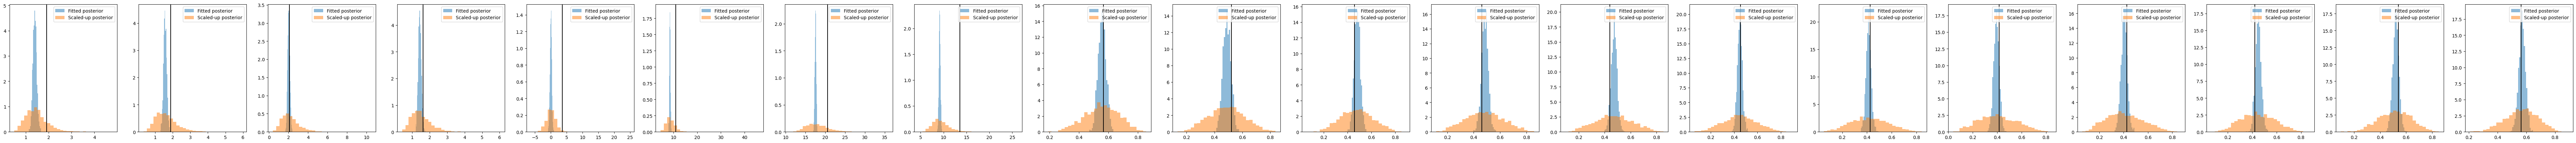

Running SBI...


Running 1000 simulations.: 100%|██████████| 1000/1000 [02:17<00:00,  7.28it/s]


 Neural network successfully converged after 79 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:11<00:00,  7.59it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 54 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:12<00:00,  7.54it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 47 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:09<00:00,  7.70it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 47 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:06<00:00,  7.91it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 35 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:18<00:00,  7.20it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 30 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:04<00:00,  8.02it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 29 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:08<00:00,  7.78it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 45 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:03<00:00,  8.08it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 48 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:14<00:00,  7.45it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs.Sampling SBI posterior and point estimate...


Drawing 2000 posterior samples: 100%|██████████| 2000/2000 [00:02<00:00, 674.24it/s]


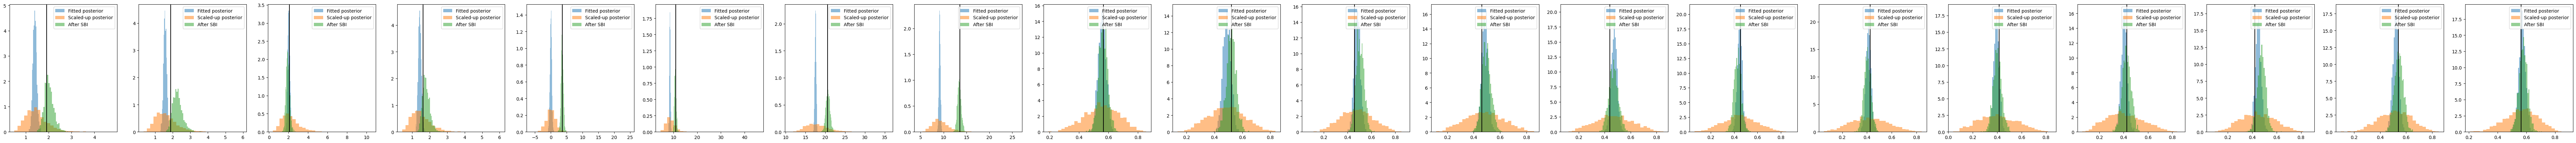

Drawing 100 posterior samples: 100%|██████████| 100/100 [00:00<00:00, 191.72it/s]


In [36]:
parameter_mask = get_parameter_mask(guide, ["Trange", "Tskew"])
sbi_posterior, samples_summary_stats, samples_obs = run_sbi(wgen, svi_result, observable_fct = case_study_3a, obs_target = obs_stats_target, scale_factor = 2.5, parameter_mask = parameter_mask, num_samples = 2000, num_rounds = num_rounds)
save_sbi_case_study("3a", sbi_posterior, samples_summary_stats, samples_obs, analysis = "analysis_v9")

## Case study 3b (seasonal Tavg, pr, overall dry days const, tight prior)

In [36]:
num_rounds = 10

In [38]:
def case_study_3b(ts, precip, Tmin, Tavg, Tmax):
    """
    ts: [1, timesteps, 4], 4: index, year, month, doy
    precip, Tmin, Tavg, Tmax: [timesteps, realizations]
    Returns: [summary_stats, realizations]
    """
    winter = jnp.isin(ts[:, :, 2], jnp.array([12, 1, 2])).T
    spring = jnp.isin(ts[:, :, 2], jnp.array([3, 4, 5])).T
    summer = jnp.isin(ts[:, :, 2], jnp.array([6, 7, 8])).T
    autumn = jnp.isin(ts[:, :, 2], jnp.array([9, 10, 11])).T

    pmean_winter = jnp.nanmean(jnp.where(winter, precip, jnp.nan), axis = 0)
    pmean_spring = jnp.nanmean(jnp.where(spring, precip, jnp.nan), axis = 0)
    pmean_summer = jnp.nanmean(jnp.where(summer, precip, jnp.nan), axis = 0)
    pmean_autumn = jnp.nanmean(jnp.where(autumn, precip, jnp.nan), axis = 0)

    wet = (precip > 0)
    pavg_wet = jnp.nanmean(wet, axis = 0)
    
    Tavg_winter = jnp.nanmean(jnp.where(winter, Tavg, jnp.nan), axis = 0)
    Tavg_spring = jnp.nanmean(jnp.where(spring, Tavg, jnp.nan), axis = 0)
    Tavg_summer = jnp.nanmean(jnp.where(summer, Tavg, jnp.nan), axis = 0)
    Tavg_autumn = jnp.nanmean(jnp.where(autumn, Tavg, jnp.nan), axis = 0)

    #icy_days = jnp.mean(Tmax < 0, axis = 0)
    #heavy_rain = jnp.mean(precip > 20, axis = 0)

    return jnp.stack([pmean_winter, pmean_spring, pmean_summer, pmean_autumn, Tavg_winter, Tavg_spring, Tavg_summer, Tavg_autumn, pavg_wet])#, icy_days])

obs['Tmin'] = obs['Tavg'] - obs['Tskew']*obs['Trange']
obs['Tmax'] = obs['Tmin'] + obs['Trange']
obs_stats = case_study_3b(jnp.expand_dims(wgen.timestamps[0,:,:], 0), obs['prec'].T, obs['Tmin'].T, obs['Tavg'].T, obs['Tmax'].T)
obs_stats

Array([[ 1.4723725 ],
       [ 1.4552826 ],
       [ 2.075413  ],
       [ 1.4105054 ],
       [ 0.17860311],
       [ 8.408174  ],
       [17.475306  ],
       [ 9.037077  ],
       [ 0.4748631 ]], dtype=float32)

In [40]:
obs_stats_target = obs_stats
obs_stats_target = obs_stats_target.at[0].mul(1.3) # pmean winter
obs_stats_target = obs_stats_target.at[1].mul(1.3) # pmean spring
obs_stats_target = obs_stats_target.at[2].mul(1.) # pmean summer
obs_stats_target = obs_stats_target.at[3].mul(1.15) # pmean autumn

obs_stats_target = obs_stats_target.at[4].add(3.4) # Tavg winter
obs_stats_target = obs_stats_target.at[5].add(2.6) # Tavg spring
obs_stats_target = obs_stats_target.at[6].add(3.1) # Tavg summer
obs_stats_target = obs_stats_target.at[7].add(4.5) # Tavg autumn

obs_stats_target

Array([[ 1.9140842],
       [ 1.8918673],
       [ 2.075413 ],
       [ 1.6220812],
       [ 3.5786033],
       [11.008173 ],
       [20.575306 ],
       [13.537077 ],
       [ 0.4748631]], dtype=float32)

Run SBI:

Sampling...


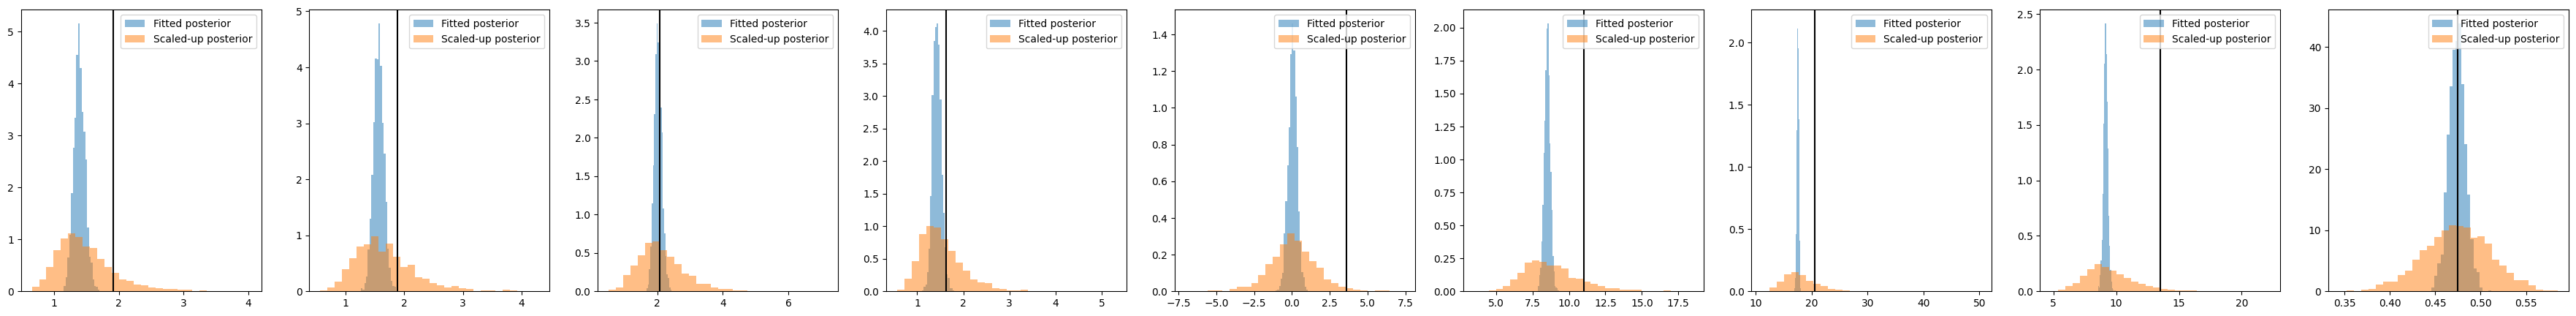

Running SBI...


Running 1000 simulations.: 100%|██████████| 1000/1000 [02:13<00:00,  7.51it/s]


 Neural network successfully converged after 71 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:25<00:00,  6.89it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 65 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:04<00:00,  8.04it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 33 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:59<00:00,  8.35it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 39 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:24<00:00,  6.93it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 34 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:04<00:00,  8.02it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 59 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:04<00:00,  8.01it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 65 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:09<00:00,  7.74it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 35 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:04<00:00,  8.04it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 37 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:12<00:00,  7.56it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 25 epochs.Sampling SBI posterior and point estimate...


Drawing 2000 posterior samples: 100%|██████████| 2000/2000 [00:03<00:00, 653.62it/s]


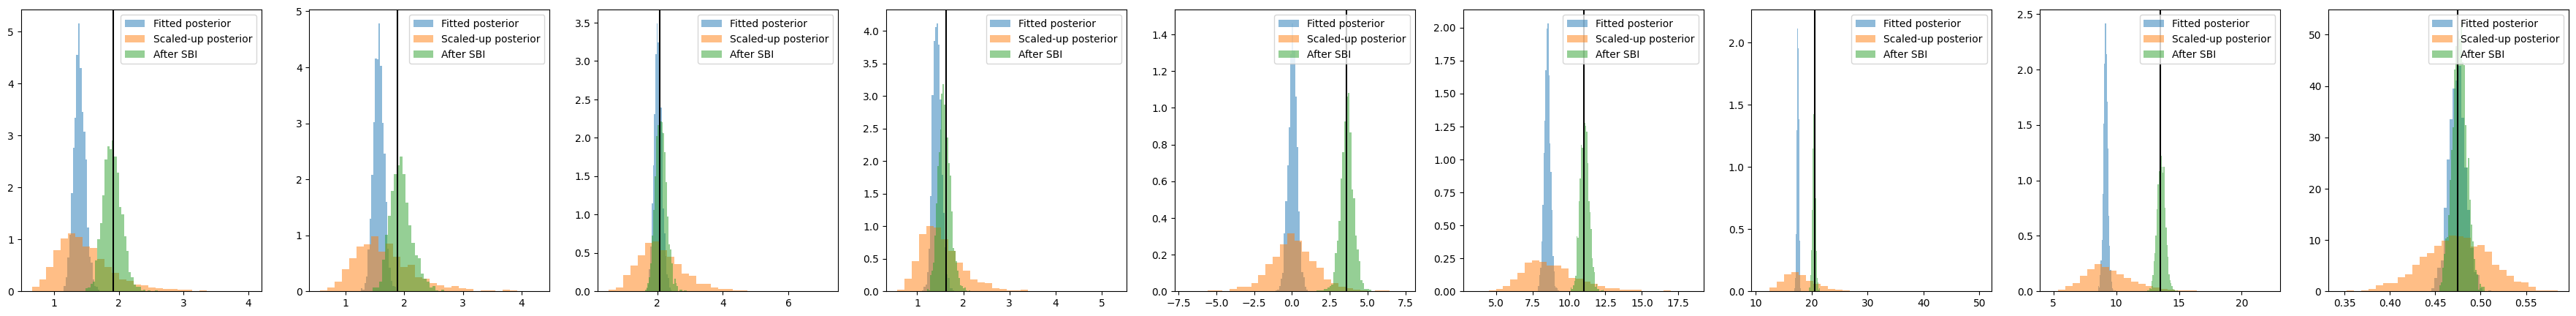

Drawing 100 posterior samples: 100%|██████████| 100/100 [00:00<00:00, 195.41it/s]


In [42]:
parameter_mask = get_parameter_mask(guide, ["Trange", "Tskew", "precip_occ_"])
sbi_posterior, samples_summary_stats, samples_obs = run_sbi(wgen, svi_result, observable_fct = case_study_3b, obs_target = obs_stats_target, scale_factor = 2.5, parameter_mask = parameter_mask, num_samples = 2000, num_rounds = num_rounds)
save_sbi_case_study("3b", sbi_posterior, samples_summary_stats, samples_obs, analysis = "analysis_v9")

## Case study 3c (seasonal Tavg, pr, overall dry days const, large prior)

In [40]:
num_rounds = 10

In [42]:
def case_study_3c(ts, precip, Tmin, Tavg, Tmax):
    """
    ts: [1, timesteps, 4], 4: index, year, month, doy
    precip, Tmin, Tavg, Tmax: [timesteps, realizations]
    Returns: [summary_stats, realizations]
    """
    winter = jnp.isin(ts[:, :, 2], jnp.array([12, 1, 2])).T
    spring = jnp.isin(ts[:, :, 2], jnp.array([3, 4, 5])).T
    summer = jnp.isin(ts[:, :, 2], jnp.array([6, 7, 8])).T
    autumn = jnp.isin(ts[:, :, 2], jnp.array([9, 10, 11])).T

    pmean_winter = jnp.nanmean(jnp.where(winter, precip, jnp.nan), axis = 0)
    pmean_spring = jnp.nanmean(jnp.where(spring, precip, jnp.nan), axis = 0)
    pmean_summer = jnp.nanmean(jnp.where(summer, precip, jnp.nan), axis = 0)
    pmean_autumn = jnp.nanmean(jnp.where(autumn, precip, jnp.nan), axis = 0)

    wet = (precip > 0)
    pavg_wet = jnp.nanmean(wet, axis = 0)
    
    Tavg_winter = jnp.nanmean(jnp.where(winter, Tavg, jnp.nan), axis = 0)
    Tavg_spring = jnp.nanmean(jnp.where(spring, Tavg, jnp.nan), axis = 0)
    Tavg_summer = jnp.nanmean(jnp.where(summer, Tavg, jnp.nan), axis = 0)
    Tavg_autumn = jnp.nanmean(jnp.where(autumn, Tavg, jnp.nan), axis = 0)

    #icy_days = jnp.mean(Tmax < 0, axis = 0)
    #heavy_rain = jnp.mean(precip > 20, axis = 0)

    return jnp.stack([pmean_winter, pmean_spring, pmean_summer, pmean_autumn, Tavg_winter, Tavg_spring, Tavg_summer, Tavg_autumn, pavg_wet])#, icy_days])

obs['Tmin'] = obs['Tavg'] - obs['Tskew']*obs['Trange']
obs['Tmax'] = obs['Tmin'] + obs['Trange']
obs_stats = case_study_3c(jnp.expand_dims(wgen.timestamps[0,:,:], 0), obs['prec'].T, obs['Tmin'].T, obs['Tavg'].T, obs['Tmax'].T)
obs_stats

Array([[ 1.4723725 ],
       [ 1.4552826 ],
       [ 2.075413  ],
       [ 1.4105054 ],
       [ 0.17860311],
       [ 8.408174  ],
       [17.475306  ],
       [ 9.037077  ],
       [ 0.4748631 ]], dtype=float32)

In [46]:
obs_stats_target = obs_stats
obs_stats_target = obs_stats_target.at[0].mul(1.3) # pmean winter
obs_stats_target = obs_stats_target.at[1].mul(1.3) # pmean spring
obs_stats_target = obs_stats_target.at[2].mul(1.) # pmean summer
obs_stats_target = obs_stats_target.at[3].mul(1.15) # pmean autumn

obs_stats_target = obs_stats_target.at[4].add(3.4) # Tavg winter
obs_stats_target = obs_stats_target.at[5].add(2.6) # Tavg spring
obs_stats_target = obs_stats_target.at[6].add(3.1) # Tavg summer
obs_stats_target = obs_stats_target.at[7].add(4.5) # Tavg autumn

obs_stats_target

Array([[ 1.9140842],
       [ 1.8918673],
       [ 2.075413 ],
       [ 1.6220812],
       [ 3.5786033],
       [11.008173 ],
       [20.575306 ],
       [13.537077 ],
       [ 0.4748631]], dtype=float32)

Run SBI:

Sampling...


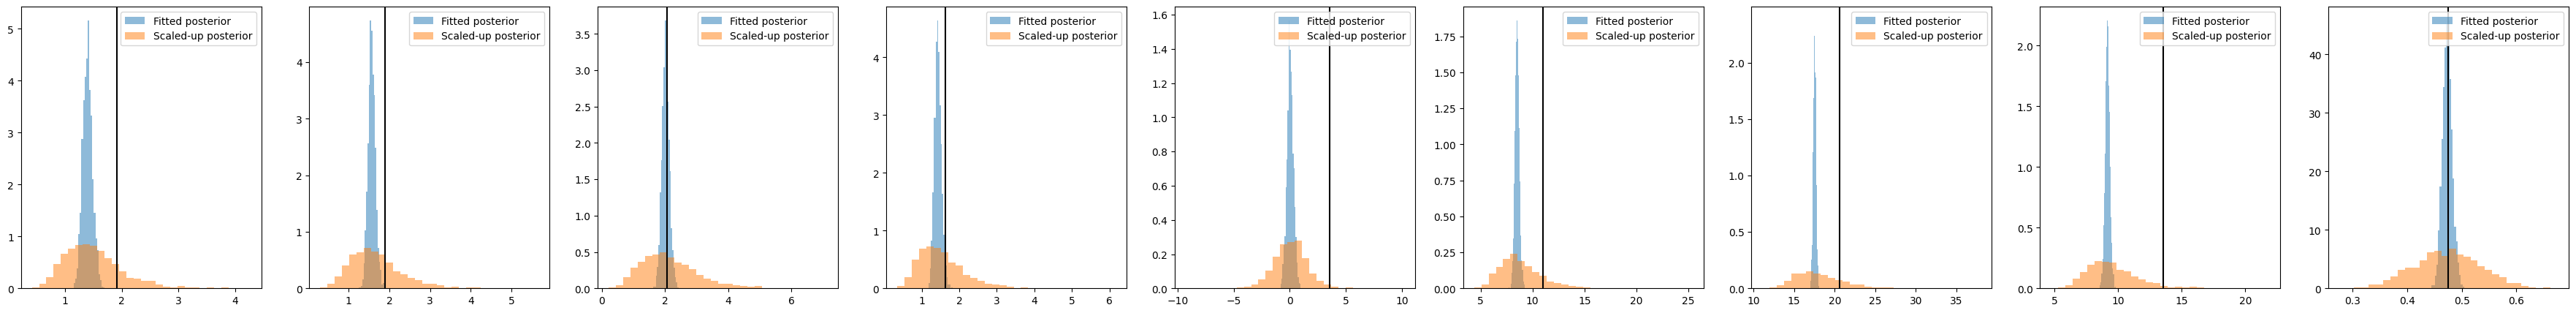

Running SBI...


Running 1000 simulations.: 100%|██████████| 1000/1000 [02:11<00:00,  7.58it/s]


 Neural network successfully converged after 68 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:02<00:00,  8.16it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 47 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:07<00:00,  7.84it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 38 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:16<00:00,  7.34it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 27 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:34<00:00,  6.48it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 67 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:20<00:00,  7.12it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 41 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:10<00:00,  7.65it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:16<00:00,  7.32it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 56 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:05<00:00,  7.96it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 67 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:13<00:00,  7.50it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 30 epochs.Sampling SBI posterior and point estimate...


Drawing 2000 posterior samples: 100%|██████████| 2000/2000 [00:03<00:00, 606.02it/s]


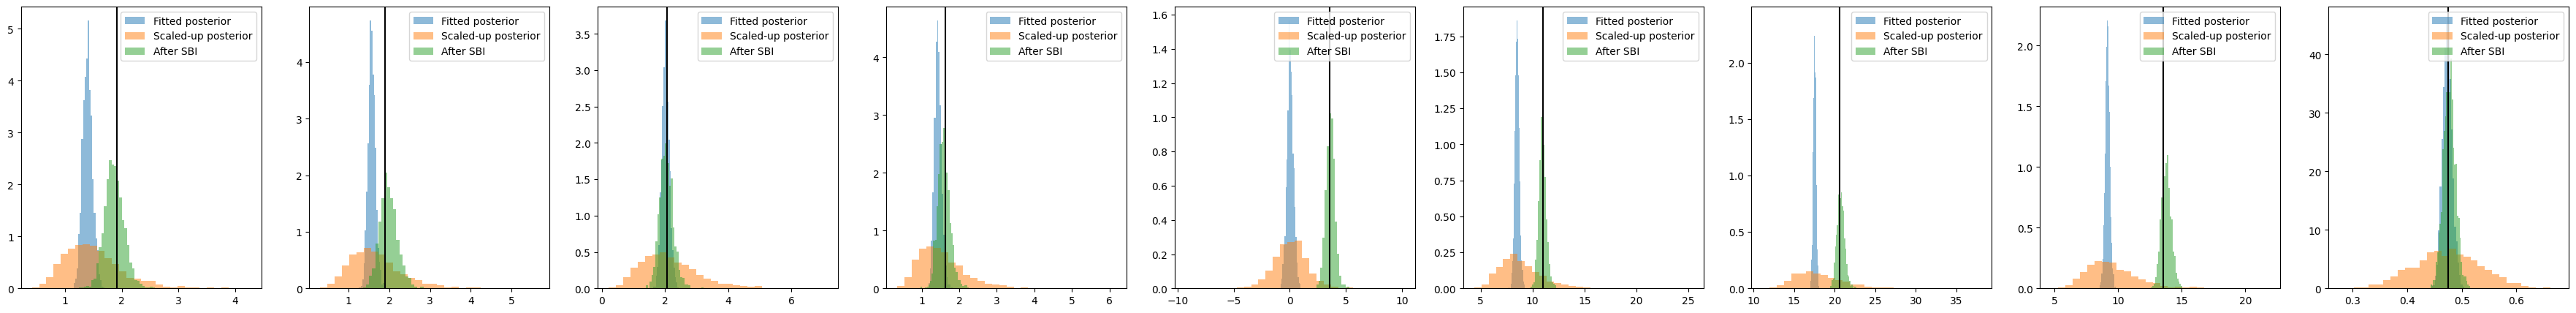

Drawing 100 posterior samples: 100%|██████████| 100/100 [00:00<00:00, 192.57it/s]


In [48]:
parameter_mask = get_parameter_mask(guide, ["Trange", "Tskew"])
sbi_posterior, samples_summary_stats, samples_obs = run_sbi(wgen, svi_result, observable_fct = case_study_3c, obs_target = obs_stats_target, scale_factor = 2.5, parameter_mask = parameter_mask, num_samples = 2000, num_rounds = num_rounds)
save_sbi_case_study("3c", sbi_posterior, samples_summary_stats, samples_obs, analysis = "analysis_v9")

## Case study 3d (seasonal Tavg, pr)

In [44]:
num_rounds = 10

In [46]:
def case_study_3d(ts, precip, Tmin, Tavg, Tmax):
    """
    ts: [1, timesteps, 4], 4: index, year, month, doy
    precip, Tmin, Tavg, Tmax: [timesteps, realizations]
    Returns: [summary_stats, realizations]
    """
    winter = jnp.isin(ts[:, :, 2], jnp.array([12, 1, 2])).T
    spring = jnp.isin(ts[:, :, 2], jnp.array([3, 4, 5])).T
    summer = jnp.isin(ts[:, :, 2], jnp.array([6, 7, 8])).T
    autumn = jnp.isin(ts[:, :, 2], jnp.array([9, 10, 11])).T

    pmean_winter = jnp.nanmean(jnp.where(winter, precip, jnp.nan), axis = 0)
    pmean_spring = jnp.nanmean(jnp.where(spring, precip, jnp.nan), axis = 0)
    pmean_summer = jnp.nanmean(jnp.where(summer, precip, jnp.nan), axis = 0)
    pmean_autumn = jnp.nanmean(jnp.where(autumn, precip, jnp.nan), axis = 0)
    
    Tavg_winter = jnp.nanmean(jnp.where(winter, Tavg, jnp.nan), axis = 0)
    Tavg_spring = jnp.nanmean(jnp.where(spring, Tavg, jnp.nan), axis = 0)
    Tavg_summer = jnp.nanmean(jnp.where(summer, Tavg, jnp.nan), axis = 0)
    Tavg_autumn = jnp.nanmean(jnp.where(autumn, Tavg, jnp.nan), axis = 0)

    #icy_days = jnp.mean(Tmax < 0, axis = 0)
    #heavy_rain = jnp.mean(precip > 20, axis = 0)

    return jnp.stack([pmean_winter, pmean_spring, pmean_summer, pmean_autumn, Tavg_winter, Tavg_spring, Tavg_summer, Tavg_autumn])#, icy_days])

obs['Tmin'] = obs['Tavg'] - obs['Tskew']*obs['Trange']
obs['Tmax'] = obs['Tmin'] + obs['Trange']
obs_stats = case_study_3d(jnp.expand_dims(wgen.timestamps[0,:,:], 0), obs['prec'].T, obs['Tmin'].T, obs['Tavg'].T, obs['Tmax'].T)
obs_stats

Array([[ 1.4723725 ],
       [ 1.4552826 ],
       [ 2.075413  ],
       [ 1.4105054 ],
       [ 0.17860311],
       [ 8.408174  ],
       [17.475306  ],
       [ 9.037077  ]], dtype=float32)

In [28]:
obs_stats_target = obs_stats
obs_stats_target = obs_stats_target.at[0].mul(1.3) # pmean winter
obs_stats_target = obs_stats_target.at[1].mul(1.3) # pmean spring
obs_stats_target = obs_stats_target.at[2].mul(1.) # pmean summer
obs_stats_target = obs_stats_target.at[3].mul(1.15) # pmean autumn

obs_stats_target = obs_stats_target.at[4].add(3.4) # Tavg winter
obs_stats_target = obs_stats_target.at[5].add(2.6) # Tavg spring
obs_stats_target = obs_stats_target.at[6].add(3.1) # Tavg summer
obs_stats_target = obs_stats_target.at[7].add(4.5) # Tavg autumn

obs_stats_target

Array([[ 1.9140842],
       [ 1.8918673],
       [ 2.075413 ],
       [ 1.6220812],
       [ 3.5786033],
       [11.008173 ],
       [20.575306 ],
       [13.537077 ]], dtype=float32)

Run SBI:

Sampling...


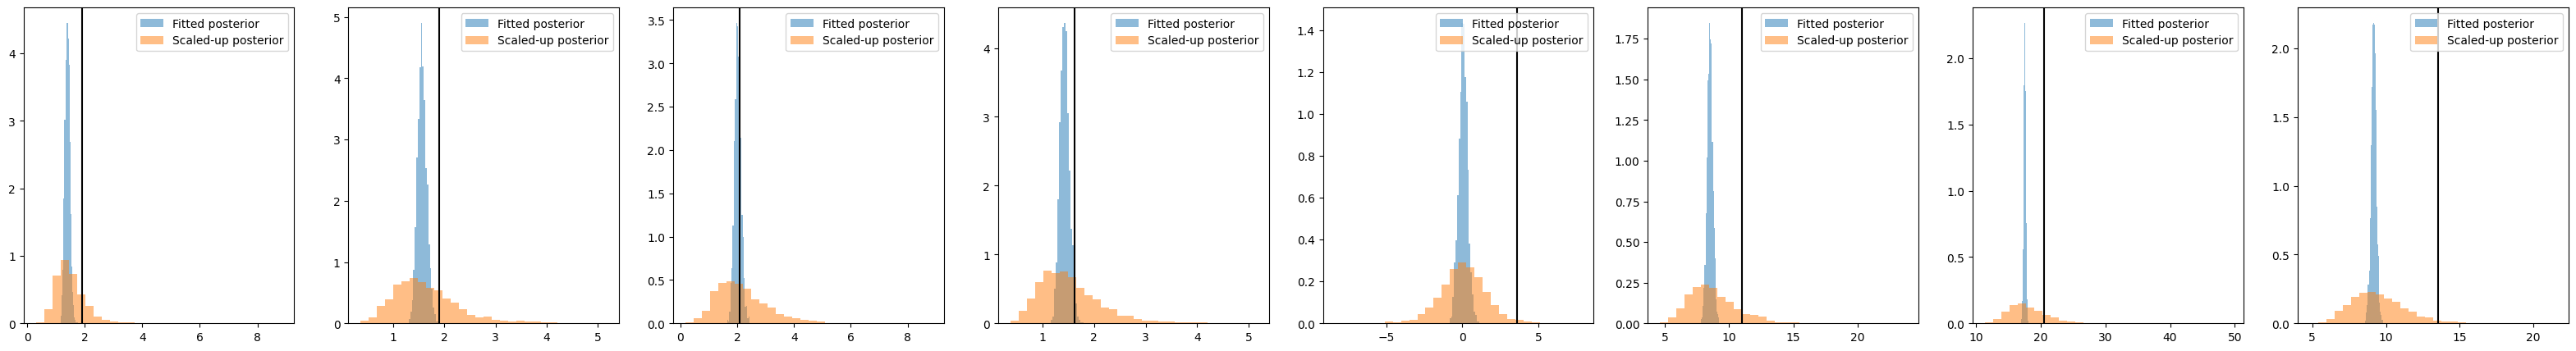

Running SBI...


Running 1000 simulations.: 100%|██████████| 1000/1000 [02:07<00:00,  7.84it/s]


 Neural network successfully converged after 75 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:06<00:00,  7.89it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 32 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:10<00:00,  7.65it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 132 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:02<00:00,  8.13it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 51 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:17<00:00,  7.27it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:05<00:00,  7.94it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 32 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:04<00:00,  8.04it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 36 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:00<00:00,  8.30it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 93 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:05<00:00,  7.95it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 63 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:05<00:00,  7.95it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 29 epochs.Sampling SBI posterior and point estimate...


Drawing 2000 posterior samples: 100%|██████████| 2000/2000 [00:03<00:00, 664.67it/s]


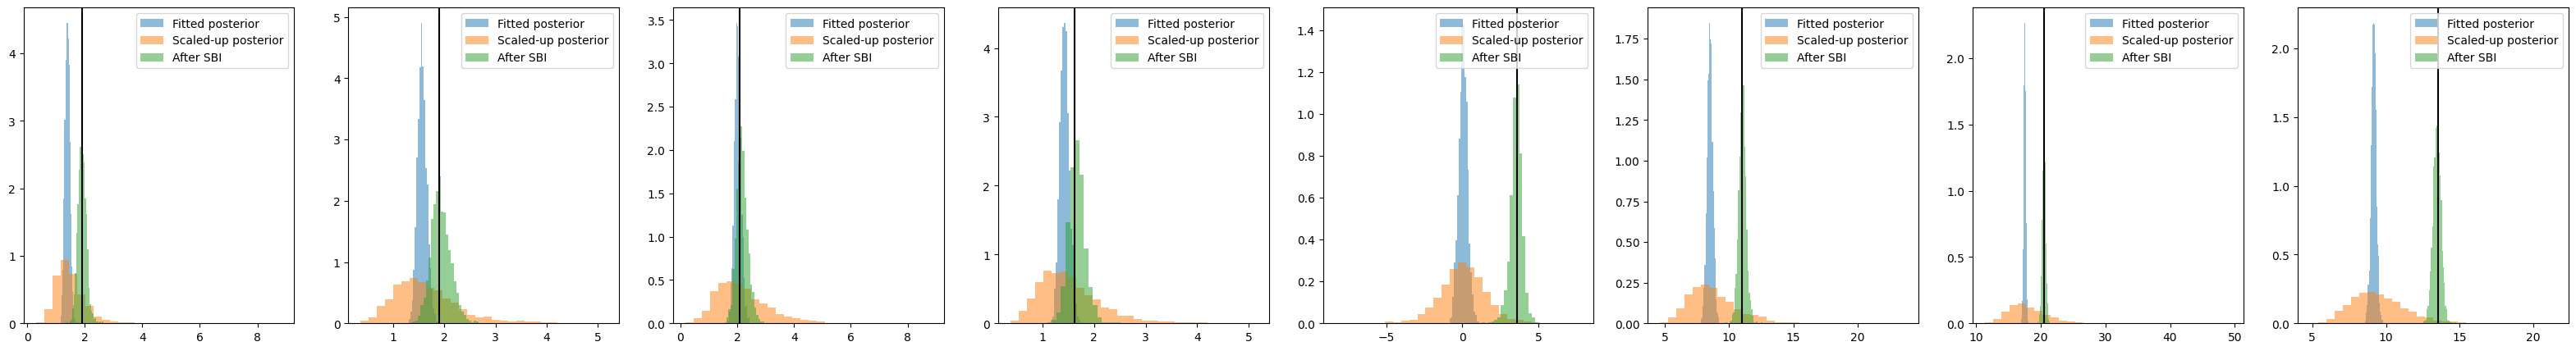

Drawing 100 posterior samples: 100%|██████████| 100/100 [00:00<00:00, 184.51it/s]


In [30]:
parameter_mask = get_parameter_mask(guide, ["Trange", "Tskew"])
sbi_posterior, samples_summary_stats, samples_obs = run_sbi(wgen, svi_result, observable_fct = case_study_3d, obs_target = obs_stats_target, scale_factor = 2.5, parameter_mask = parameter_mask, num_samples = 2000, num_rounds = num_rounds)
save_sbi_case_study("3d", sbi_posterior, samples_summary_stats, samples_obs, analysis = "analysis_v9")

# Analysis

In [134]:
def make_line_plots(fut, hist, obs, time, target = None, ax = None, color_fut = "lightblue"):
    if ax is None:
        fig, ax = plt.subplots(figsize = (6,4))
        
    df_preds = pd.DataFrame(fut.squeeze().T)
    df_preds["time"] = time
    df_preds = df_preds.melt(id_vars="time", value_name="pred")
    df_preds = df_preds.groupby([df_preds.time.dt.month, df_preds.variable]).mean().drop(columns="time").reset_index()
    sns.lineplot(df_preds, x = "time", y = "pred", units = "variable", estimator = None, color = color_fut, alpha = 0.2, ax = ax)
    
    df_preds = pd.DataFrame(hist.squeeze().T)
    df_preds["time"] = time
    df_preds = df_preds.melt(id_vars="time", value_name="pred")
    df_preds = df_preds.groupby([df_preds.time.dt.month, df_preds.variable]).mean().drop(columns="time").reset_index()
    sns.lineplot(df_preds, x = "time", y = "pred", units = "variable", estimator = None, color = "grey", alpha = 0.2, ax = ax)
    
    df_obs = pd.DataFrame({"obs": obs.squeeze(), "time": basin_data_train.index})
    df_obs = df_obs.groupby(df_obs.time.dt.month)["obs"].mean().reset_index()
    sns.lineplot(df_obs, x="time", y="obs", color = "black", ax = ax)

    if target is not None:
        ax.axhline(target, color = "darkblue", linestyle = "dashed")

def add_seasonal_targets(targets, ax):
    ax.hlines(y = targets[0], xmin = 1, xmax = 2.5, color = "darkblue", linestyle = "dashed")
    ax.hlines(y = targets[1], xmin = 2.5, xmax = 5.5, color = "darkblue", linestyle = "dashed")
    ax.hlines(y = targets[2], xmin = 5.5, xmax = 8.5, color = "darkblue", linestyle = "dashed")
    ax.hlines(y = targets[3], xmin = 8.5, xmax = 11.5, color = "darkblue", linestyle = "dashed")
    ax.hlines(y = targets[0], xmin = 11.5, xmax = 12, color = "darkblue", linestyle = "dashed")

def add_monthly_targets(targets, ax):
    for i in range(2, 12):
        ax.hlines(y = targets[i-1], xmin = i-0.5, xmax = i+0.5, color = "darkblue", linestyle = "dashed")
    ax.hlines(y = targets[0], xmin = 1, xmax = 1.5, color = "darkblue", linestyle = "dashed")
    ax.hlines(y = targets[11], xmin = 11.5, xmax = 12, color = "darkblue", linestyle = "dashed")


In [136]:
def load_sbi_case_study(case_study, analysis = "analysis_v9"):
    with open(os.path.join("sbi_results", analysis, f"case_study_{case_study}_sbi_posterior.pkl"), "rb") as handle:
        sbi_posterior = pickle.load(handle)
    samples_summary_stats= torch.load(os.path.join("sbi_results", analysis, f"case_study_{case_study}_samples_summary_stats.pt"))
    samples_obs = torch.load(os.path.join("sbi_results", analysis, f"case_study_{case_study}_samples_summary_obs.pt"))
    return sbi_posterior, samples_summary_stats, samples_obs

## Case study 1

In [138]:
sbi_posterior, samples_summary_stats, samples_obs = load_sbi_case_study("1a")

In [139]:
obs_stats_target = case_study_1a(wgen.timestamps[0,:,:], obs['prec'].T, obs['Tmin'].T, obs['Tavg'].T, obs['Tmax'].T)
obs_stats_target = obs_stats_target.at[0].mul(1.2)
obs_stats_target = obs_stats_target.at[2].add(3.5)


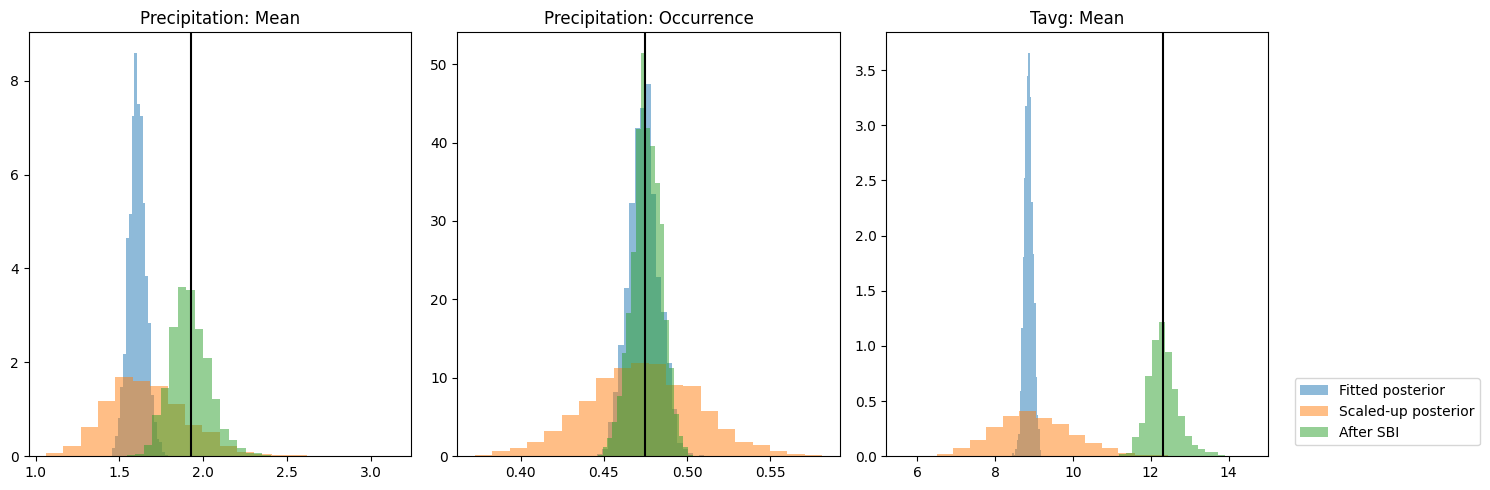

In [68]:
# Plot
titles = ["Precipitation: Mean", "Precipitation: Occurrence", "Tavg: Mean"]
fig, axs = plt.subplots(1, obs_stats_target.shape[0], figsize = (obs_stats_target.shape[0]*5, 5), layout="tight")
for i in range(obs_stats_target.shape[0]):
    axs[i].hist(samples_summary_stats["fitted_posterior"][:, i].numpy(), bins = 20, density = True, alpha = 0.5, label = "Fitted posterior")
    axs[i].hist(samples_summary_stats["sbi_proposal"][:, i].numpy(), bins = 20, density = True, alpha = 0.5, label = "Scaled-up posterior")
    axs[i].hist(samples_summary_stats["sbi_posterior"][:, i].numpy(), bins = 20, density = True, alpha = 0.5, label = "After SBI")
    axs[i].set_title(titles[i])
    axs[i].axvline(obs_stats_target[i,:].flatten(), c= "black")
axs[-1].legend(bbox_to_anchor = (1.05, 0.2))
plt.savefig("plots/analysis_v9/case_study_1.png", dpi = 300)


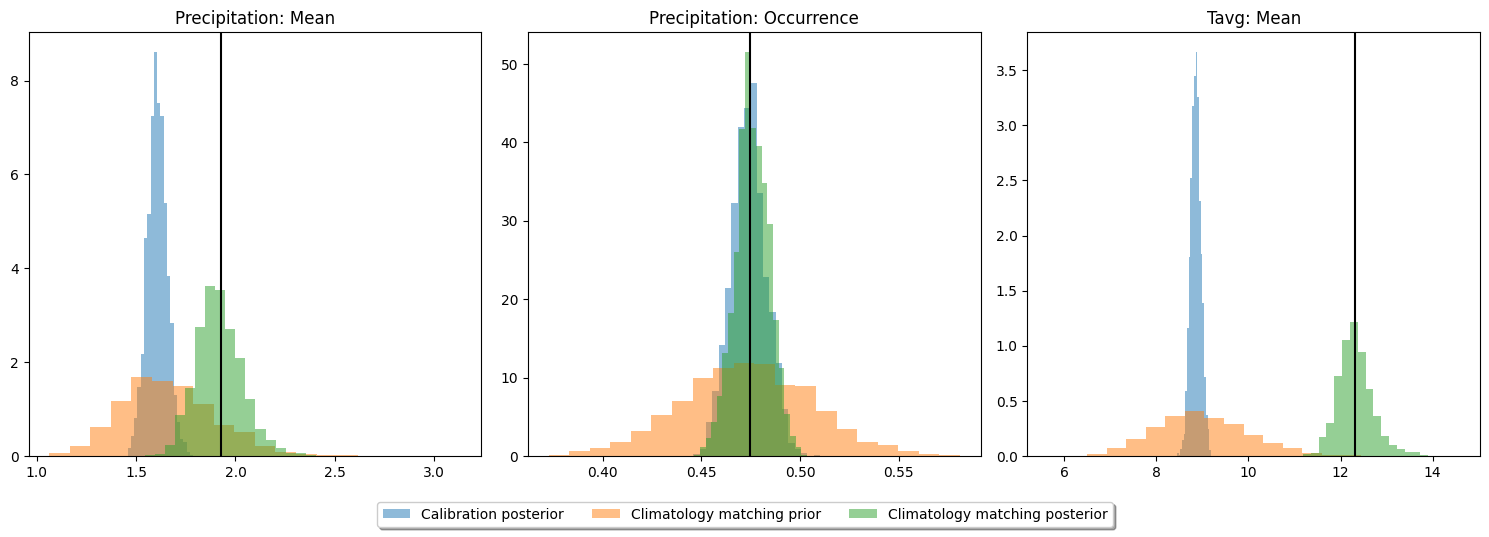

In [76]:
# Plot
titles = ["Precipitation: Mean", "Precipitation: Occurrence", "Tavg: Mean"]
fig, axs = plt.subplots(1, obs_stats_target.shape[0], figsize = (obs_stats_target.shape[0]*5, 5), layout="tight")
for i in range(obs_stats_target.shape[0]):
    axs[i].hist(samples_summary_stats["fitted_posterior"][:, i].numpy(), bins = 20, density = True, alpha = 0.5, label = "Calibration posterior")
    axs[i].hist(samples_summary_stats["sbi_proposal"][:, i].numpy(), bins = 20, density = True, alpha = 0.5, label = "Climatology matching prior")
    axs[i].hist(samples_summary_stats["sbi_posterior"][:, i].numpy(), bins = 20, density = True, alpha = 0.5, label = "Climatology matching posterior")
    axs[i].set_title(titles[i])
    axs[i].axvline(obs_stats_target[i,:].flatten(), c= "black")
#axs[-1].legend(bbox_to_anchor = (1.05, 0.2))

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.0),
          fancybox=True, shadow=True, ncol=5)
plt.savefig("plots/analysis_v9/case_study_1.png", dpi = 300, bbox_inches='tight')


In [78]:
obs_hist = samples_obs["mean_fitted_posterior"]
obs_fut = samples_obs["sbi_posterior_point_estimate"]

pr_hist, tmin_hist, tavg_hist, tmax_hist = obs_hist[:, :, 0], obs_hist[:, :, 1], obs_hist[:, :, 2], obs_hist[:, :, 3]
pr_fut, tmin_fut, tavg_fut, tmax_fut = obs_fut[:, :, 0], obs_fut[:, :, 1], obs_fut[:, :, 2], obs_fut[:, :, 3]

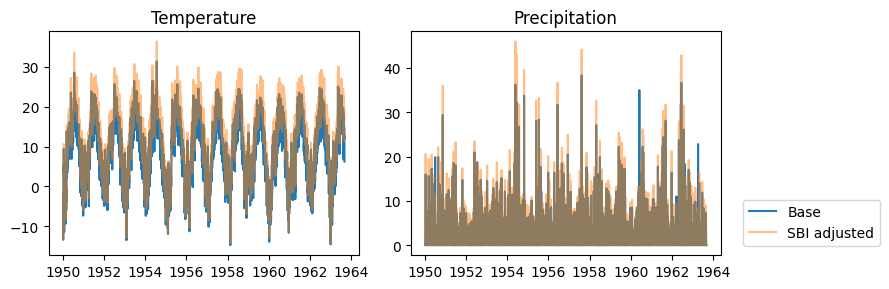

In [141]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (9, 3), layout = "tight")

ax1.plot(basin_data_train.index[:5000], tavg_hist[0, :5000], label = "Base")
ax1.plot(basin_data_train.index[:5000], tavg_fut[0, :5000], alpha = 0.5, label = "SBI adjusted")
ax1.set_title("Temperature")

ax2.plot(basin_data_train.index[:5000], pr_hist[0, :5000], label = "Base")
ax2.plot(basin_data_train.index[:5000], pr_fut[0, :5000], alpha = 0.5, label = "SBI adjusted")
ax2.legend(bbox_to_anchor = (1.05, 0.28))
ax2.set_title("Precipitation")

plt.savefig("plots/analysis_v9/case_study_1_temp_precip.png")

In [142]:
case_study_1a(jnp.expand_dims(wgen.timestamps[0,:,:], 0), *t2j(obs_fut.swapaxes(-1, 0))).std(axis = 1)


Array([0.03849218, 0.00562311, 0.08729366], dtype=float32)

In [143]:
case_study_1a(jnp.expand_dims(wgen.timestamps[0,:,:], 0), *t2j(obs_hist.swapaxes(-1, 0))).std(axis = 1)


Array([0.03124899, 0.0054968 , 0.0702616 ], dtype=float32)

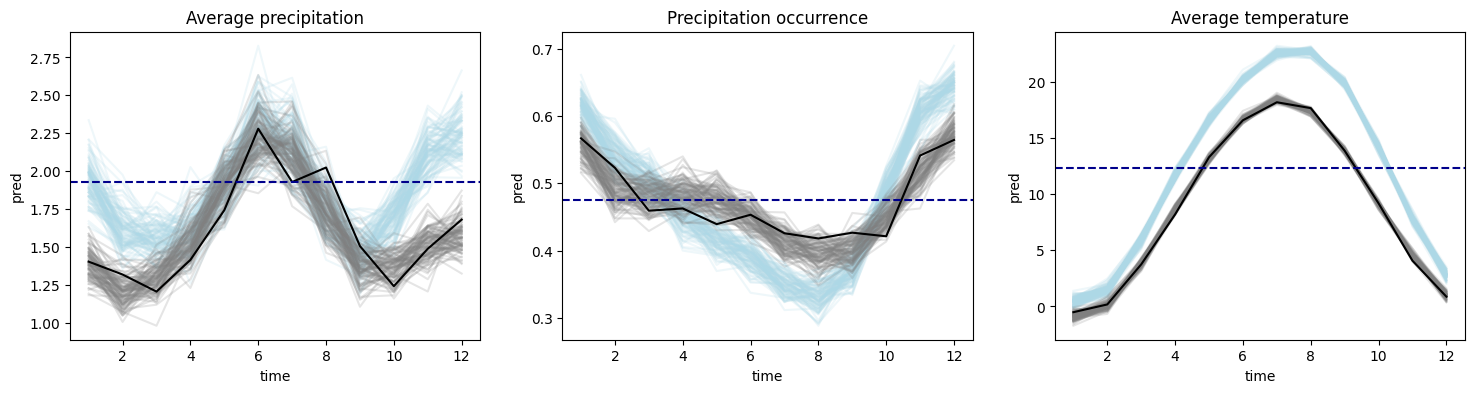

In [144]:
fig, axs = plt.subplots(1,3, figsize = (18,4))
make_line_plots(pr_fut, pr_hist, obs["prec"], basin_data_train.index, ax = axs[0], target = obs_stats_target[0])
#add_seasonal_targets(obs_stats_target[:4], axs[0])
axs[0].set_title("Average precipitation")

make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, basin_data_train.index, ax = axs[1], target = obs_stats_target[1])
#add_seasonal_targets(obs_stats_target[4:9], axs[1])
axs[1].set_title("Precipitation occurrence")

make_line_plots(tavg_fut, tavg_hist, obs["Tavg"], basin_data_train.index, ax = axs[2], target = obs_stats_target[2])
#add_seasonal_targets(obs_stats_target[8:], axs[2])
axs[2].set_title("Average temperature")

plt.savefig("plots/analysis_v9/case_study_1_summary_plots.png")

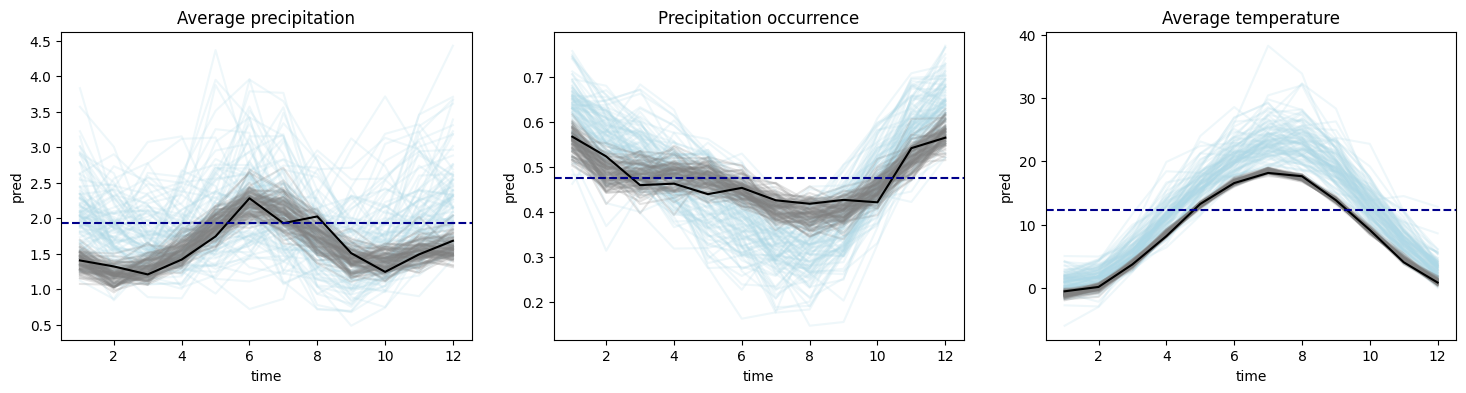

In [145]:
obs_hist = samples_obs["fitted_posterior"]
obs_fut = samples_obs["sbi_posterior"]

pr_hist, tmin_hist, tavg_hist, tmax_hist = obs_hist[:, :, 0], obs_hist[:, :, 1], obs_hist[:, :, 2], obs_hist[:, :, 3]
pr_fut, tmin_fut, tavg_fut, tmax_fut = obs_fut[:, :, 0], obs_fut[:, :, 1], obs_fut[:, :, 2], obs_fut[:, :, 3]

fig, axs = plt.subplots(1,3, figsize = (18,4))
make_line_plots(pr_fut, pr_hist, obs["prec"], basin_data_train.index, ax = axs[0], target = obs_stats_target[0])
#add_seasonal_targets(obs_stats_target[:4], axs[0])
axs[0].set_title("Average precipitation")

make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, basin_data_train.index, ax = axs[1], target = obs_stats_target[1])
#add_seasonal_targets(obs_stats_target[4:9], axs[1])
axs[1].set_title("Precipitation occurrence")

make_line_plots(tavg_fut, tavg_hist, obs["Tavg"], basin_data_train.index, ax = axs[2], target = obs_stats_target[2])
#add_seasonal_targets(obs_stats_target[8:], axs[2])
axs[2].set_title("Average temperature")

plt.savefig("plots/analysis_v9/case_study_1_summary_plots_full_posterior.png")

In [146]:
samples_obs.keys()

dict_keys(['mean_fitted_posterior', 'fitted_posterior', 'sbi_posterior', 'sbi_posterior_point_estimate'])

In [147]:
np.mean(pr_fut.numpy() > 20)

0.010461117196056954

In [148]:
np.mean(pr_hist.numpy() > 20)*2

0.01047973713033954

## Case study 2

In [80]:
sbi_posterior, samples_summary_stats, samples_obs = load_sbi_case_study("2")

In [82]:
obs_stats_target = case_study_2(jnp.expand_dims(wgen.timestamps[0,:,:], 0), obs['prec'].T, obs['Tmin'].T, obs['Tavg'].T, obs['Tmax'].T)
obs_stats_target = obs_stats_target.at[0].add(3.1) # Tavg 
obs_stats_target = obs_stats_target.at[1].mul(1.3) # pmean 
obs_stats_target = obs_stats_target.at[2].mul(2.) # heavy_rain
obs_stats_target = obs_stats_target.at[3].set(0.01) # icy_days: 3 per year
obs_stats_target = obs_stats_target.at[4].set(0.08) # tropical_nights: 30 per year
obs_stats_target = obs_stats_target.at[5].mul(1.2) # Trangemean



Case study 2:

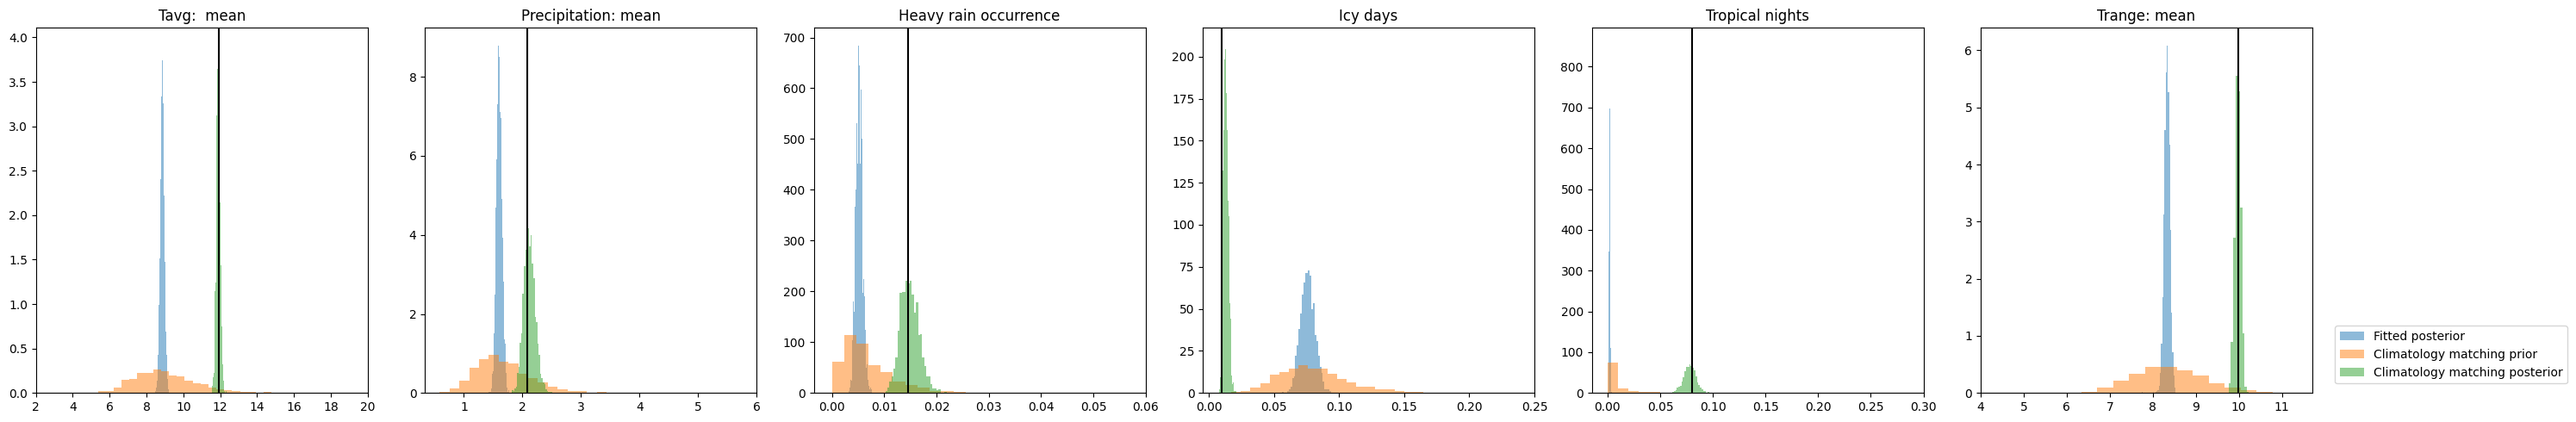

In [85]:
# Plot
titles = ["Tavg:  mean", "Precipitation: mean", "Heavy rain occurrence", "Icy days", "Tropical nights", "Trange: mean"]
left_xlims = [2, None, None, None, None, 4]
right_xlims = [20, 6, 0.06, None, 0.30, None]

fig, axs = plt.subplots(1, obs_stats_target.shape[0], figsize = (obs_stats_target.shape[0]*5, 5), layout = "tight")
for i in range(obs_stats_target.shape[0]):
    axs[i].hist(samples_summary_stats["fitted_posterior"][:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "Fitted posterior")
    axs[i].hist(samples_summary_stats["sbi_proposal"][:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "Climatology matching prior")
    axs[i].hist(samples_summary_stats["sbi_posterior"][:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "Climatology matching posterior")
    #axs[i].legend(loc = "upper right")
    axs[i].set_title(titles[i])
    axs[i].axvline(obs_stats_target[i,:].flatten(), c= "black")
    axs[i].set_xlim(left = left_xlims[i], right = right_xlims[i])
axs[-1].legend(bbox_to_anchor = (1.05, 0.2))
plt.savefig("plots/analysis_v9/case_study_2_wide.png", dpi = 300)

In [86]:
obs_stats

Array([[ 1.4723725 ],
       [ 1.4552826 ],
       [ 2.075413  ],
       [ 1.4105054 ],
       [ 0.55232817],
       [ 0.45369565],
       [ 0.4321739 ],
       [ 0.46263736],
       [ 0.17860311],
       [ 8.408174  ],
       [17.475306  ],
       [ 9.037077  ],
       [12.        ]], dtype=float32)

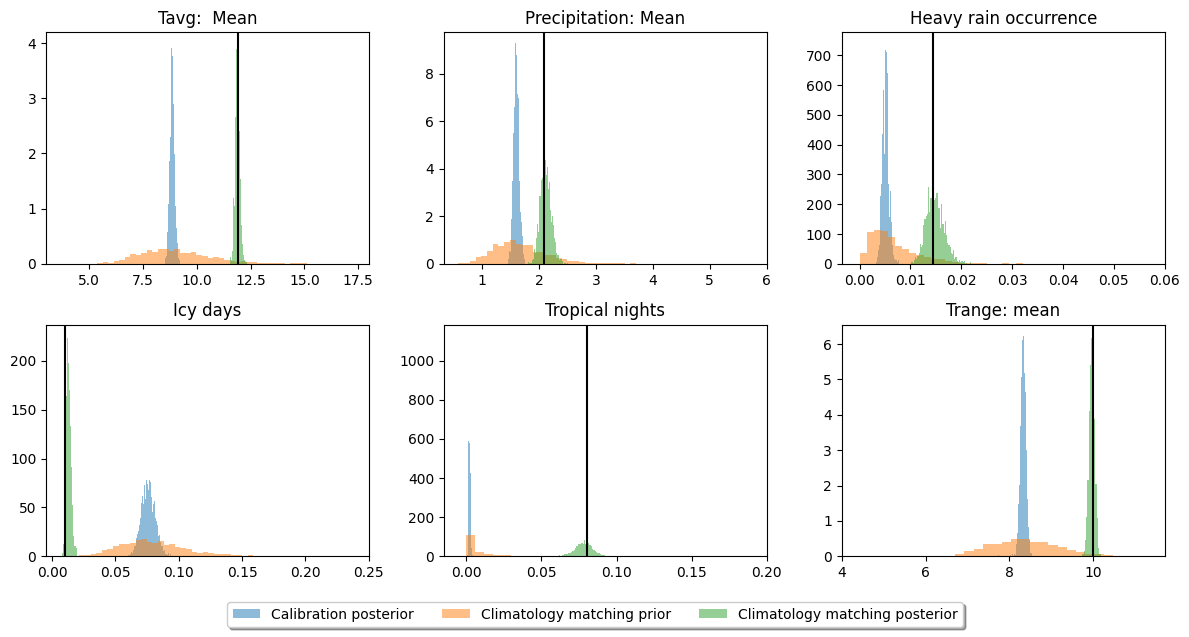

In [89]:
# Plot
titles = ["Tavg:  Mean", "Precipitation: Mean", "Heavy rain occurrence", "Icy days", "Tropical nights", "Trange: mean"]
left_xlims = [3, None, None, None, None, 4]
right_xlims = [18, 6, 0.06, None, 0.2, None]

fig, axs = plt.subplots(2, 3, figsize = (12, 6), layout = "tight")
axs = axs.ravel()
for i in range(obs_stats_target.shape[0]):
    axs[i].hist(samples_summary_stats["fitted_posterior"][:, i].numpy(), bins = 50, density = True, alpha = 0.5, label = "Calibration posterior")
    axs[i].hist(samples_summary_stats["sbi_proposal"][:, i].numpy(), bins = 50, density = True, alpha = 0.5, label = "Climatology matching prior")
    axs[i].hist(samples_summary_stats["sbi_posterior"][:, i].numpy(), bins = 50, density = True, alpha = 0.5, label = "Climatology matching posterior")
    #axs[i].legend(loc = "upper right")
    axs[i].set_title(titles[i])
    axs[i].axvline(obs_stats_target[i,:].flatten(), c= "black")
    axs[i].set_xlim(left = left_xlims[i], right = right_xlims[i])
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.0),
          fancybox=True, shadow=True, ncol=5)
plt.savefig("plots/analysis_v9/case_study_2.png", dpi = 300, bbox_inches='tight')

In [68]:
obs_hist = t2j(samples_obs["mean_fitted_posterior"])
obs_fut = t2j(samples_obs["sbi_posterior_point_estimate"])

pr_hist, tmin_hist, tavg_hist, tmax_hist = obs_hist[:, :, 0], obs_hist[:, :, 1], obs_hist[:, :, 2], obs_hist[:, :, 3]
pr_fut, tmin_fut, tavg_fut, tmax_fut = obs_fut[:, :, 0], obs_fut[:, :, 1], obs_fut[:, :, 2], obs_fut[:, :, 3]

trange_fut = tmax_fut - tmin_fut
trange_hist = tmax_hist - tmin_hist
tskew_fut = (tavg_fut - tmin_fut)/trange_fut
tskew_hist = (tavg_hist - tmin_hist)/trange_hist

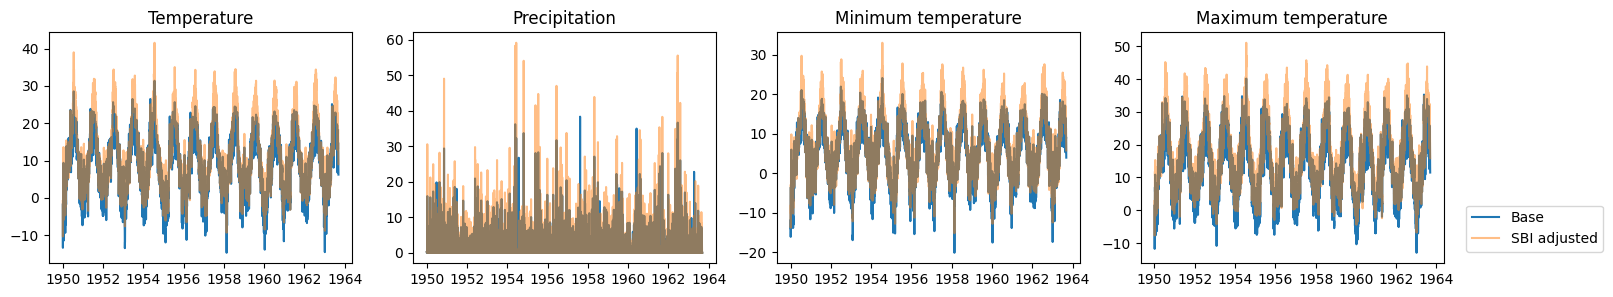

In [69]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (18, 3))

ax1.plot(basin_data_train.index[:5000], tavg_hist[0, :5000], label = "Base")
ax1.plot(basin_data_train.index[:5000], tavg_fut[0, :5000], alpha = 0.5, label = "SBI adjusted")
ax1.set_title("Temperature")

ax2.plot(basin_data_train.index[:5000], pr_hist[0, :5000], label = "Base")
ax2.plot(basin_data_train.index[:5000], pr_fut[0, :5000], alpha = 0.5, label = "SBI adjusted")
ax2.set_title("Precipitation")

ax3.plot(basin_data_train.index[:5000], tmin_hist[0, :5000], label = "Base")
ax3.plot(basin_data_train.index[:5000], tmin_fut[0, :5000], alpha = 0.5, label = "SBI adjusted")
ax3.set_title("Minimum temperature")

ax4.plot(basin_data_train.index[:5000], tmax_hist[0, :5000], label = "Base")
ax4.plot(basin_data_train.index[:5000], tmax_fut[0, :5000], alpha = 0.5, label = "SBI adjusted")
ax4.legend(bbox_to_anchor = (1.05, 0.28))
ax4.set_title("Maximum temperature")

plt.savefig("plots/analysis_v9/case_study_2_timeseries.png", dpi = 300)

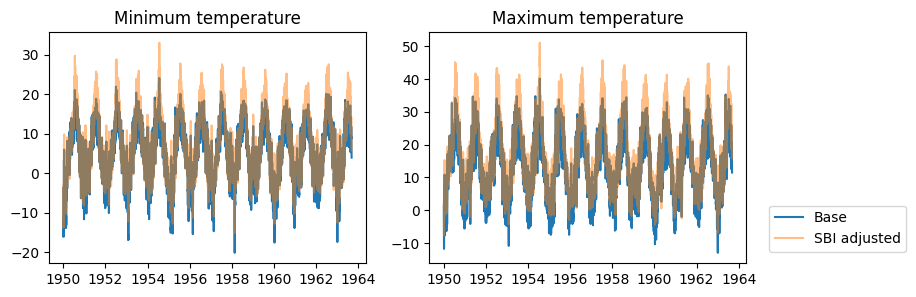

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (9, 3))

ax1.plot(basin_data_train.index[:5000], tmin_hist[0, :5000], label = "Base")
ax1.plot(basin_data_train.index[:5000], tmin_fut[0, :5000], alpha = 0.5, label = "Adjusted")
ax1.set_title("Minimum temperature")

ax2.plot(basin_data_train.index[:5000], tmax_hist[0, :5000], label = "Base")
ax2.plot(basin_data_train.index[:5000], tmax_fut[0, :5000], alpha = 0.5, label = "SBI adjusted")
ax2.legend(bbox_to_anchor = (1.05, 0.28))
ax2.set_title("Maximum temperature")

plt.savefig("plots/analysis_v9/case_study_2_timeseries.png", dpi = 300)

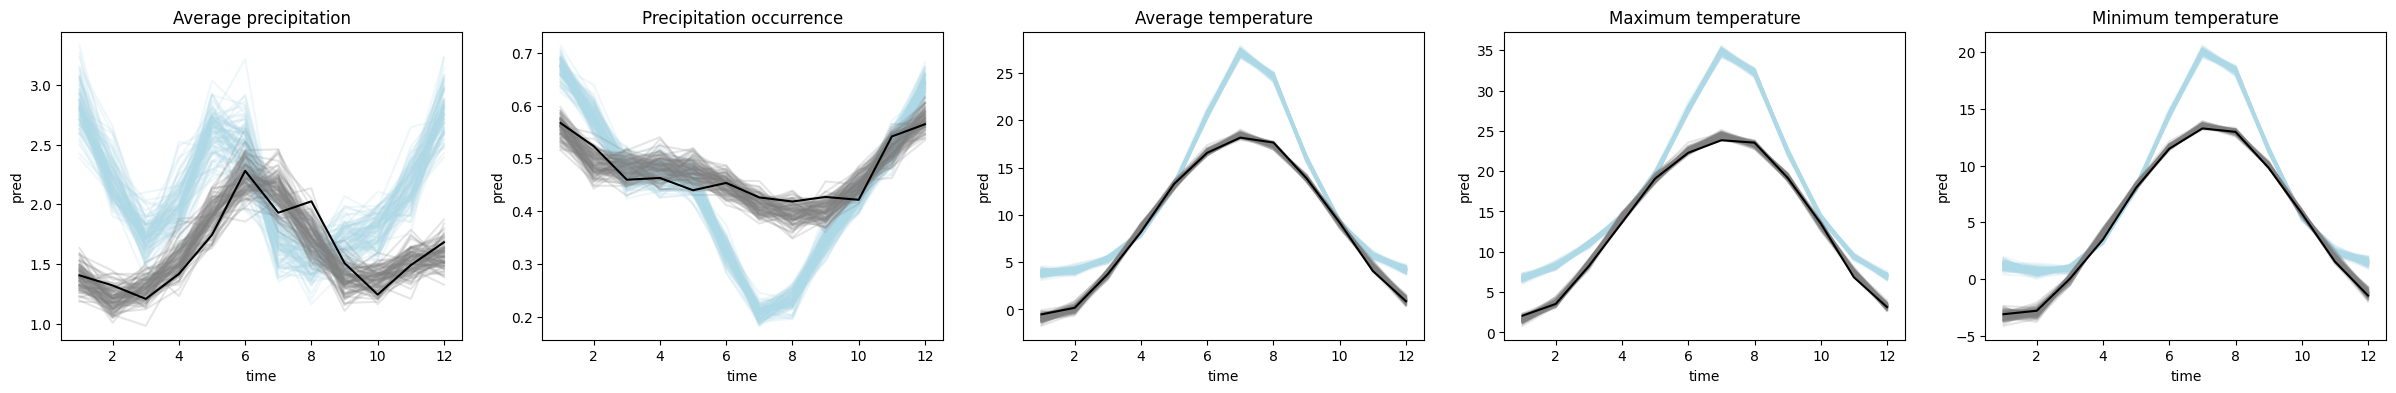

In [73]:
fig, axs = plt.subplots(1,5, figsize = (30,4))
make_line_plots(pr_fut, pr_hist, obs["prec"], basin_data_train.index, ax = axs[0])
#add_seasonal_targets(obs_stats_target[:4], axs[0])
axs[0].set_title("Average precipitation")

make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, basin_data_train.index, ax = axs[1])
#add_seasonal_targets(obs_stats_target[4:9], axs[1])
axs[1].set_title("Precipitation occurrence")

make_line_plots(tavg_fut, tavg_hist, obs["Tavg"], basin_data_train.index, ax = axs[2])
#add_seasonal_targets(obs_stats_target[8:], axs[2])
axs[2].set_title("Average temperature")


make_line_plots(tmax_fut, tmax_hist, obs["Tmax"], basin_data_train.index, ax = axs[3])
#add_seasonal_targets(obs_stats_target[8:], axs[2])
axs[3].set_title("Maximum temperature")

make_line_plots(tmin_fut, tmin_hist, obs["Tmin"], basin_data_train.index, ax = axs[4])
#add_seasonal_targets(obs_stats_target[8:], axs[2])
axs[4].set_title("Minimum temperature")

plt.savefig("plots/analysis_v9/case_study_2_summary_plots.png")

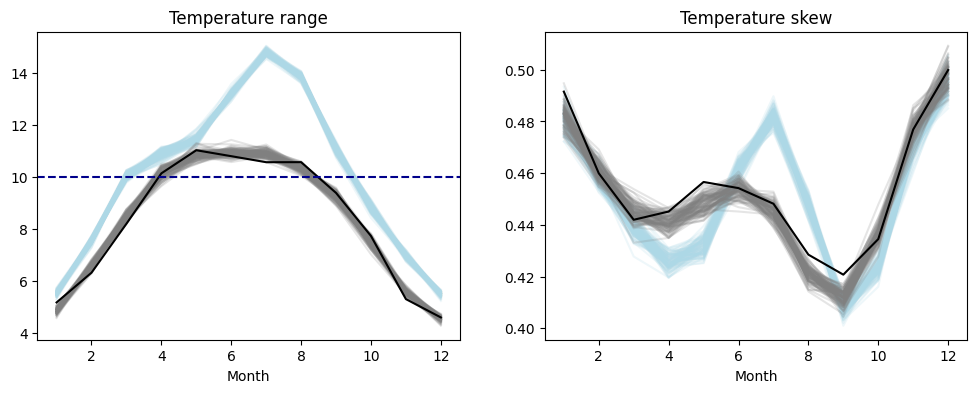

In [74]:
fig, axs = plt.subplots(1,2, figsize = (12,4))
make_line_plots(trange_fut, trange_hist, obs["Trange"], basin_data_train.index, target=obs_stats_target[-1], ax = axs[0])
axs[0].set_title("Temperature range")
make_line_plots(tskew_fut, tskew_hist, obs["Tskew"], basin_data_train.index, ax = axs[1])
axs[1].set_title("Temperature skew")
axs[0].set_xlabel("Month")
axs[1].set_xlabel("Month")
axs[0].set_ylabel("")
axs[1].set_ylabel("")


plt.savefig("plots/analysis_v9/case_study_2_summary_plots_range_skew.png")

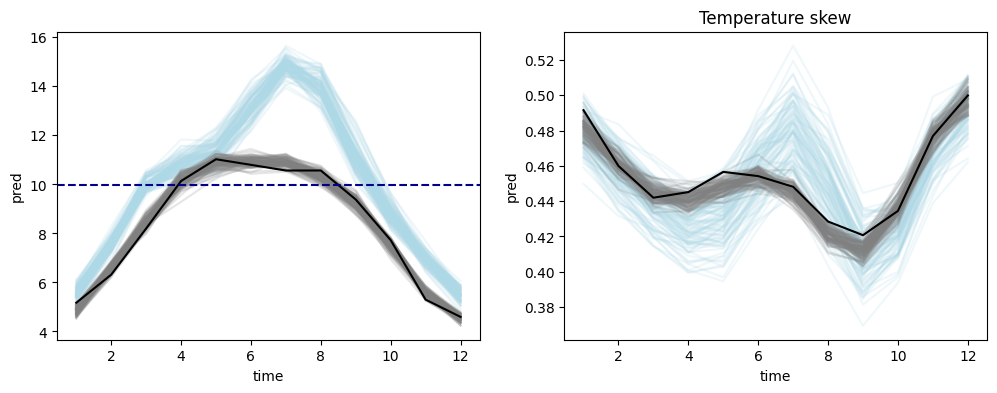

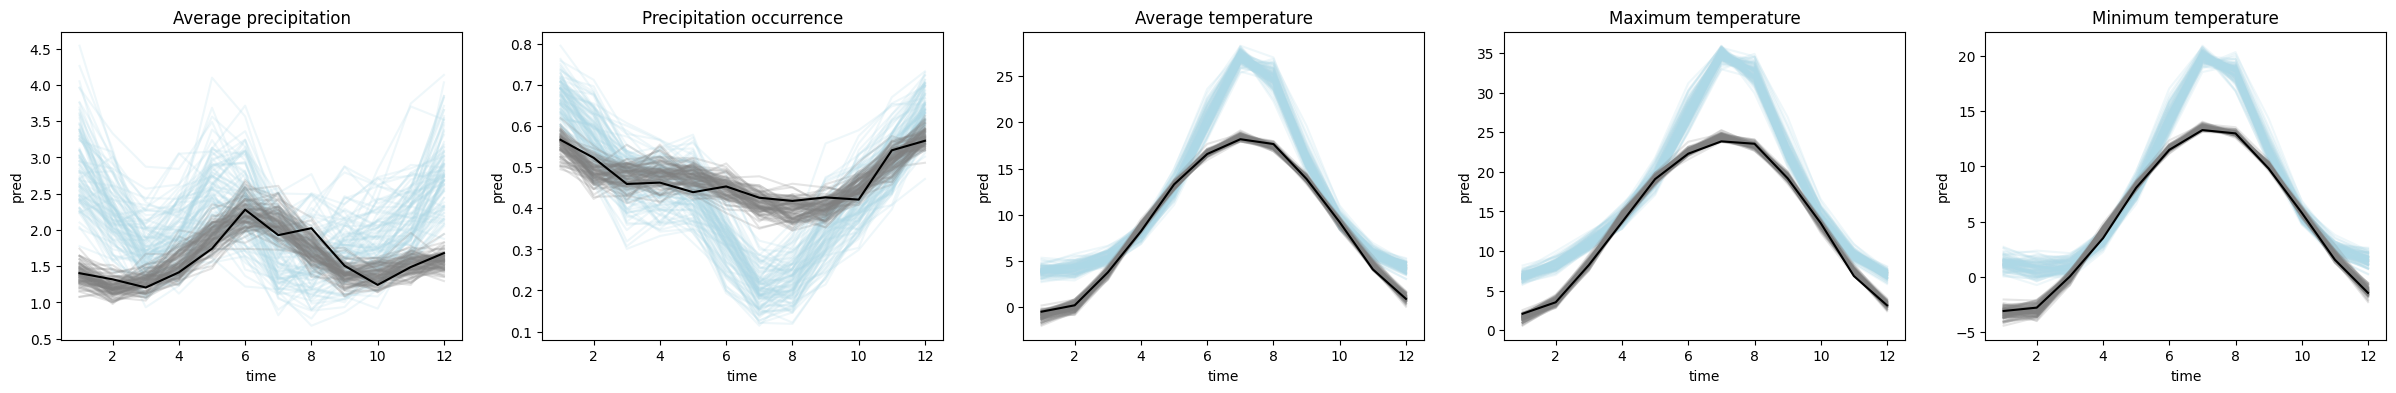

In [76]:
obs_hist = samples_obs["fitted_posterior"]
obs_fut = samples_obs["sbi_posterior"]

pr_hist, tmin_hist, tavg_hist, tmax_hist = obs_hist[:, :, 0], obs_hist[:, :, 1], obs_hist[:, :, 2], obs_hist[:, :, 3]
pr_fut, tmin_fut, tavg_fut, tmax_fut = obs_fut[:, :, 0], obs_fut[:, :, 1], obs_fut[:, :, 2], obs_fut[:, :, 3]

trange_fut = tmax_fut - tmin_fut
trange_hist = tmax_hist - tmin_hist
tskew_fut = (tavg_fut - tmin_fut)/trange_fut
tskew_hist = (tavg_hist - tmin_hist)/trange_hist



fig, axs = plt.subplots(1,2, figsize = (12,4))
make_line_plots(trange_fut, trange_hist, obs["Trange"], basin_data_train.index, target=obs_stats_target[-1], ax = axs[0])
axs[1].set_title("Temperature range")
make_line_plots(tskew_fut, tskew_hist, obs["Tskew"], basin_data_train.index, ax = axs[1])
axs[1].set_title("Temperature skew")

plt.savefig("plots/analysis_v9/case_study_2_summary_plots_range_skew_full_posterior.png")


fig, axs = plt.subplots(1,5, figsize = (30,4))
make_line_plots(pr_fut, pr_hist, obs["prec"], basin_data_train.index, ax = axs[0])
#add_seasonal_targets(obs_stats_target[:4], axs[0])
axs[0].set_title("Average precipitation")

make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, basin_data_train.index, ax = axs[1])
#add_seasonal_targets(obs_stats_target[4:9], axs[1])
axs[1].set_title("Precipitation occurrence")

make_line_plots(tavg_fut, tavg_hist, obs["Tavg"], basin_data_train.index, ax = axs[2])
#add_seasonal_targets(obs_stats_target[8:], axs[2])
axs[2].set_title("Average temperature")


make_line_plots(tmax_fut, tmax_hist, obs["Tmax"], basin_data_train.index, ax = axs[3])
#add_seasonal_targets(obs_stats_target[8:], axs[2])
axs[3].set_title("Maximum temperature")

make_line_plots(tmin_fut, tmin_hist, obs["Tmin"], basin_data_train.index, ax = axs[4])
#add_seasonal_targets(obs_stats_target[8:], axs[2])
axs[4].set_title("Minimum temperature")

plt.savefig("plots/analysis_v9/case_study_2_summary_plots_full_posterior.png")

## Case study 3

### Overview part a)

In [91]:
sbi_posterior, samples_summary_stats, samples_obs = load_sbi_case_study("3a")

In [92]:
obs_stats_target = case_study_3a(jnp.expand_dims(wgen.timestamps[0,:,:], 0), obs['prec'].T, obs['Tmin'].T, obs['Tavg'].T, obs['Tmax'].T)
obs_stats_target = obs_stats_target.at[0].mul(1.3) # pmean winter
obs_stats_target = obs_stats_target.at[1].mul(1.3) # pmean spring
obs_stats_target = obs_stats_target.at[2].mul(1.) # pmean summer
obs_stats_target = obs_stats_target.at[3].mul(1.15) # pmean autumn

obs_stats_target = obs_stats_target.at[4].add(3.4) # Tavg winter
obs_stats_target = obs_stats_target.at[5].add(2.6) # Tavg spring
obs_stats_target = obs_stats_target.at[6].add(3.1) # Tavg summer
obs_stats_target = obs_stats_target.at[7].add(4.5) # Tavg autumn


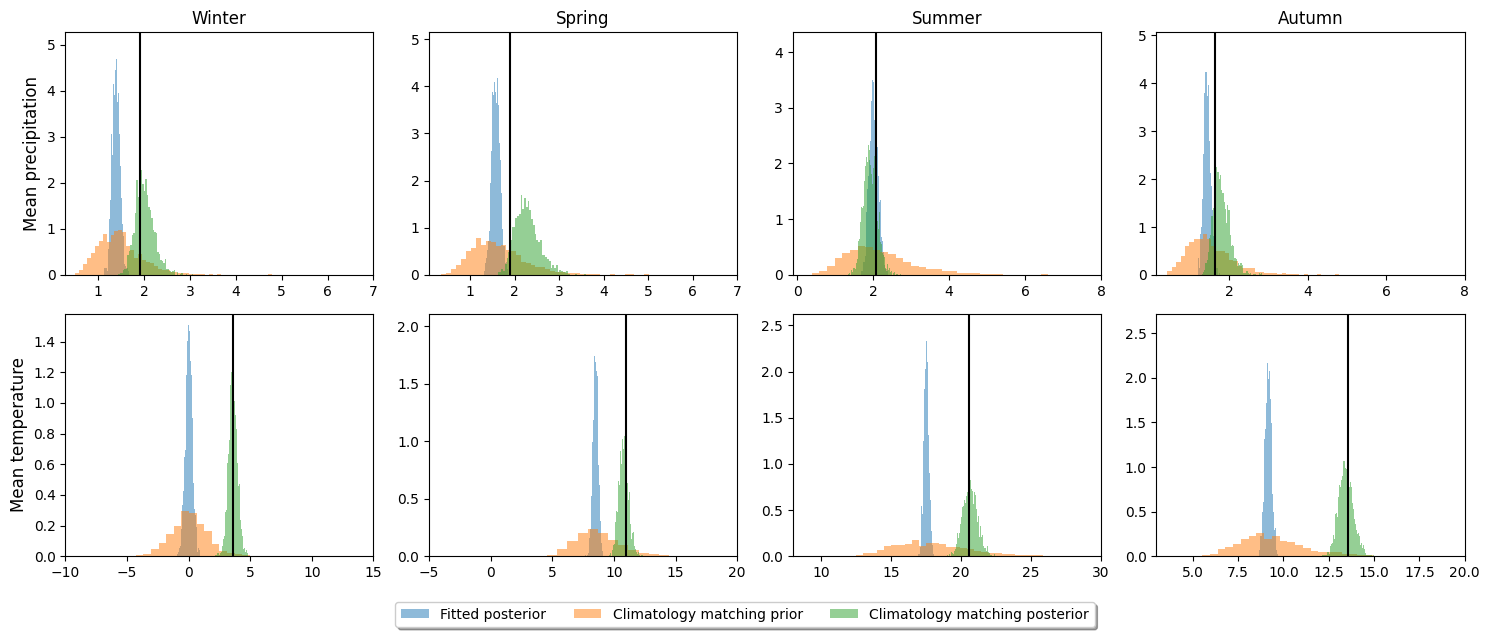

In [95]:
# Plot
idxs = [0, 1, 2, 3, 4, 5, 6, 7]

left_xlims = [None, None, None, None, -10, -5, 8, 3]
right_xlims = [7, 7, 8, 8, 15, 20, 30, 20]

samples_summary_stats_reduced_plot = dict()
samples_summary_stats_reduced_plot["fitted_posterior"] = samples_summary_stats["fitted_posterior"][:, idxs]
samples_summary_stats_reduced_plot["sbi_proposal"] = samples_summary_stats["sbi_proposal"][:, idxs]
samples_summary_stats_reduced_plot["sbi_posterior"] = samples_summary_stats["sbi_posterior"][:, idxs]
obs_stats_target_reduced_plot = obs_stats_target[idxs, :]

fig, axs = plt.subplots(2, 4, figsize = (15, 6), layout = "tight")
axs[0, 0].set_ylabel("Mean precipitation", size = "large")
axs[1, 0].set_ylabel("Mean temperature", size = "large")

axs = axs.ravel()
axs[0].set_title("Winter")
axs[1].set_title("Spring")
axs[2].set_title("Summer")
axs[3].set_title("Autumn")

for i in range(obs_stats_target_reduced_plot.shape[0]):
    axs[i].hist(samples_summary_stats_reduced_plot["fitted_posterior"][:, i].numpy(), bins = 50, density = True, alpha = 0.5, label = "Fitted posterior")
    axs[i].hist(samples_summary_stats_reduced_plot["sbi_proposal"][:, i].numpy(), bins = 50, density = True, alpha = 0.5, label = "Climatology matching prior")
    axs[i].hist(samples_summary_stats_reduced_plot["sbi_posterior"][:, i].numpy(), bins = 50, density = True, alpha = 0.5, label = "Climatology matching posterior")
    #axs[i].legend(loc = "upper right")
    #axs[i].set_title(titles[i])
    axs[i].axvline(obs_stats_target_reduced_plot[i,:].flatten(), c= "black")
    axs[i].set_xlim(left = left_xlims[i], right = right_xlims[i])
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.0),
          fancybox=True, shadow=True, ncol=5)
plt.savefig("plots/analysis_v9/case_study_3a.png", dpi = 300, bbox_inches='tight')

In [167]:
obs_hist = t2j(samples_obs["mean_fitted_posterior"])
obs_fut = t2j(samples_obs["sbi_posterior_point_estimate"])

pr_hist, tmin_hist, tavg_hist, tmax_hist = obs_hist[:, :, 0], obs_hist[:, :, 1], obs_hist[:, :, 2], obs_hist[:, :, 3]
pr_fut, tmin_fut, tavg_fut, tmax_fut = obs_fut[:, :, 0], obs_fut[:, :, 1], obs_fut[:, :, 2], obs_fut[:, :, 3]

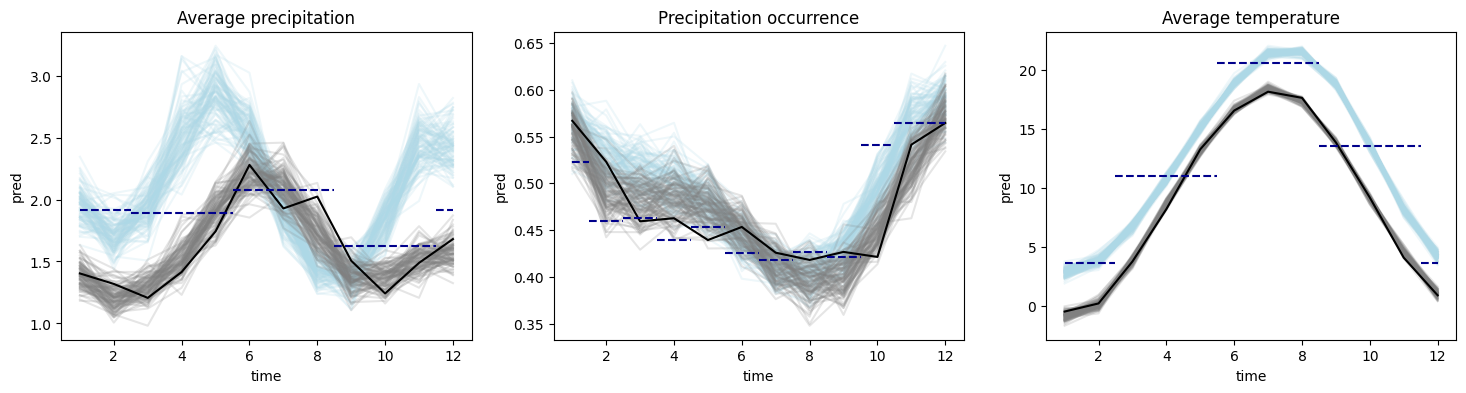

In [168]:
fig, axs = plt.subplots(1,3, figsize = (18,4))
make_line_plots(pr_fut, pr_hist, obs["prec"], basin_data_train.index, ax = axs[0])
add_seasonal_targets(obs_stats_target[:4], axs[0])
axs[0].set_title("Average precipitation")

make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, basin_data_train.index, ax = axs[1])
add_monthly_targets(obs_stats_target[9:], axs[1])
axs[1].set_title("Precipitation occurrence")

make_line_plots(tavg_fut, tavg_hist, obs["Tavg"], basin_data_train.index, ax = axs[2])
add_seasonal_targets(obs_stats_target[4:9], axs[2])
axs[2].set_title("Average temperature")

plt.savefig("plots/analysis_v9/case_study_3a_ensemble.png", dpi = 300)

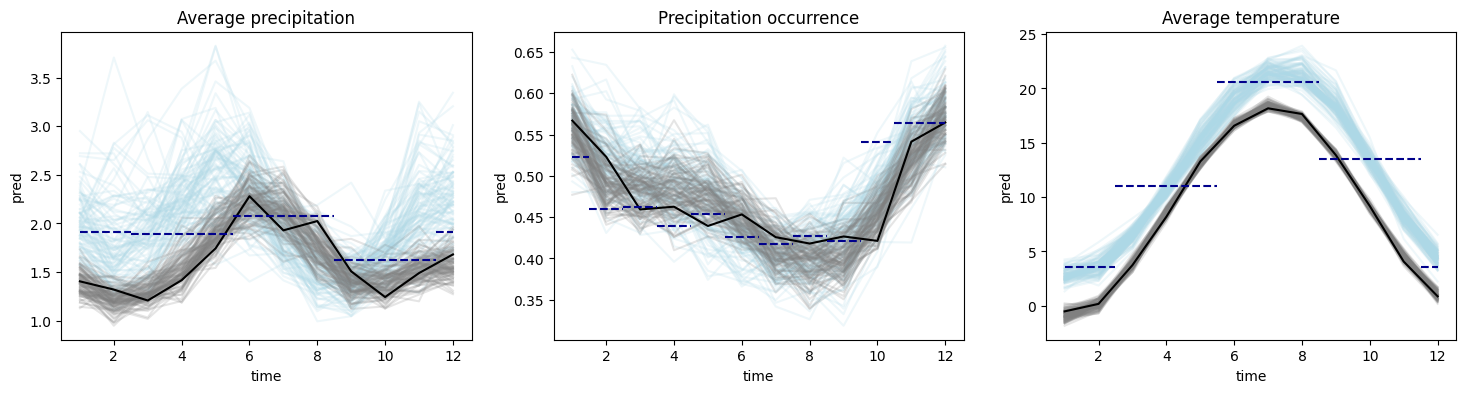

In [169]:
obs_hist = samples_obs["fitted_posterior"]
obs_fut = samples_obs["sbi_posterior"]

pr_hist, tmin_hist, tavg_hist, tmax_hist = obs_hist[:, :, 0], obs_hist[:, :, 1], obs_hist[:, :, 2], obs_hist[:, :, 3]
pr_fut, tmin_fut, tavg_fut, tmax_fut = obs_fut[:, :, 0], obs_fut[:, :, 1], obs_fut[:, :, 2], obs_fut[:, :, 3]

fig, axs = plt.subplots(1,3, figsize = (18,4))
make_line_plots(pr_fut, pr_hist, obs["prec"], basin_data_train.index, ax = axs[0])
add_seasonal_targets(obs_stats_target[:4], axs[0])
axs[0].set_title("Average precipitation")

make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, basin_data_train.index, ax = axs[1])
add_monthly_targets(obs_stats_target[9:], axs[1])
axs[1].set_title("Precipitation occurrence")

make_line_plots(tavg_fut, tavg_hist, obs["Tavg"], basin_data_train.index, ax = axs[2])
add_seasonal_targets(obs_stats_target[4:9], axs[2])
axs[2].set_title("Average temperature")

plt.savefig("plots/analysis_v9/case_study_3a_ensemble_full_posterior.png", dpi = 300)

### Overview part b)

In [96]:
sbi_posterior, samples_summary_stats, samples_obs = load_sbi_case_study("3b")

In [97]:
obs_stats_target = case_study_3b(jnp.expand_dims(wgen.timestamps[0,:,:], 0), obs['prec'].T, obs['Tmin'].T, obs['Tavg'].T, obs['Tmax'].T)
obs_stats_target = obs_stats_target.at[0].mul(1.3) # pmean winter
obs_stats_target = obs_stats_target.at[1].mul(1.3) # pmean spring
obs_stats_target = obs_stats_target.at[2].mul(1.) # pmean summer
obs_stats_target = obs_stats_target.at[3].mul(1.15) # pmean autumn

obs_stats_target = obs_stats_target.at[4].add(3.4) # Tavg winter
obs_stats_target = obs_stats_target.at[5].add(2.6) # Tavg spring
obs_stats_target = obs_stats_target.at[6].add(3.1) # Tavg summer
obs_stats_target = obs_stats_target.at[7].add(4.5) # Tavg autumn

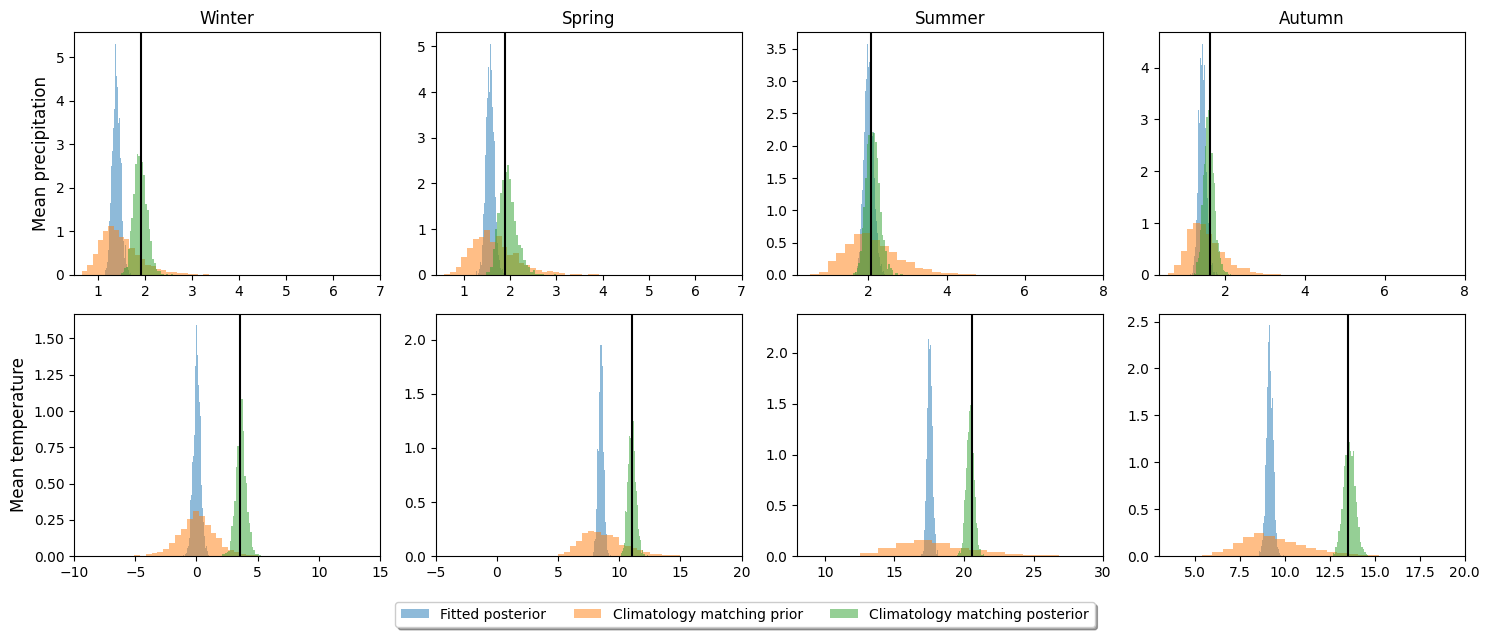

In [99]:
# Plot
idxs = [0, 1, 2, 3, 4, 5, 6, 7]

left_xlims = [None, None, None, None, -10, -5, 8, 3]
right_xlims = [7, 7, 8, 8, 15, 20, 30, 20]

samples_summary_stats_reduced_plot = dict()
samples_summary_stats_reduced_plot["fitted_posterior"] = samples_summary_stats["fitted_posterior"][:, idxs]
samples_summary_stats_reduced_plot["sbi_proposal"] = samples_summary_stats["sbi_proposal"][:, idxs]
samples_summary_stats_reduced_plot["sbi_posterior"] = samples_summary_stats["sbi_posterior"][:, idxs]
obs_stats_target_reduced_plot = obs_stats_target[idxs, :]

fig, axs = plt.subplots(2, 4, figsize = (15, 6), layout = "tight")
axs[0, 0].set_ylabel("Mean precipitation", size = "large")
axs[1, 0].set_ylabel("Mean temperature", size = "large")

axs = axs.ravel()
axs[0].set_title("Winter")
axs[1].set_title("Spring")
axs[2].set_title("Summer")
axs[3].set_title("Autumn")

for i in range(obs_stats_target_reduced_plot.shape[0]):
    axs[i].hist(samples_summary_stats_reduced_plot["fitted_posterior"][:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "Fitted posterior")
    axs[i].hist(samples_summary_stats_reduced_plot["sbi_proposal"][:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "Climatology matching prior")
    axs[i].hist(samples_summary_stats_reduced_plot["sbi_posterior"][:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "Climatology matching posterior")
    #axs[i].legend(loc = "upper right")
    #axs[i].set_title(titles[i])
    axs[i].axvline(obs_stats_target_reduced_plot[i,:].flatten(), c= "black")
    axs[i].set_xlim(left = left_xlims[i], right = right_xlims[i])
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.0),
          fancybox=True, shadow=True, ncol=5)
plt.savefig("plots/analysis_v9/case_study_3b.png", dpi = 300, bbox_inches='tight')

In [174]:
obs_hist = t2j(samples_obs["mean_fitted_posterior"])
obs_fut = t2j(samples_obs["sbi_posterior_point_estimate"])

pr_hist, tmin_hist, tavg_hist, tmax_hist = obs_hist[:, :, 0], obs_hist[:, :, 1], obs_hist[:, :, 2], obs_hist[:, :, 3]
pr_fut, tmin_fut, tavg_fut, tmax_fut = obs_fut[:, :, 0], obs_fut[:, :, 1], obs_fut[:, :, 2], obs_fut[:, :, 3]

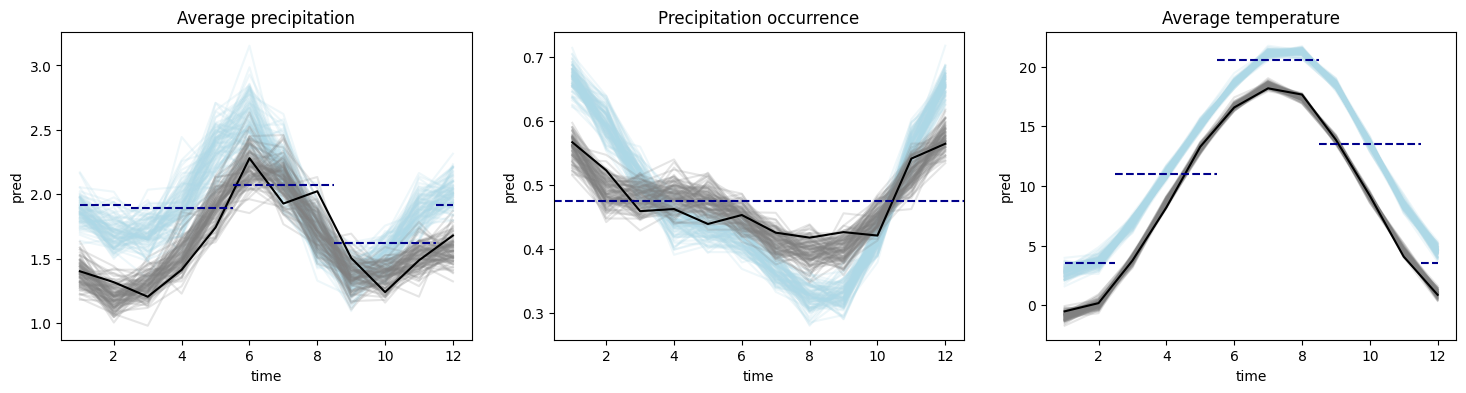

In [175]:
fig, axs = plt.subplots(1,3, figsize = (18,4))
make_line_plots(pr_fut, pr_hist, obs["prec"], basin_data_train.index, ax = axs[0])
add_seasonal_targets(obs_stats_target[:4], axs[0])
axs[0].set_title("Average precipitation")

make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, basin_data_train.index, ax = axs[1], target = obs_stats_target[-1])
axs[1].set_title("Precipitation occurrence")

make_line_plots(tavg_fut, tavg_hist, obs["Tavg"], basin_data_train.index, ax = axs[2])
add_seasonal_targets(obs_stats_target[4:], axs[2])
axs[2].set_title("Average temperature")
plt.savefig("plots/analysis_v9/case_study_3b_ensemble.png")

In [176]:
obs_hist = t2j(samples_obs["fitted_posterior"])
obs_fut = t2j(samples_obs["sbi_posterior"])

pr_hist, tmin_hist, tavg_hist, tmax_hist = obs_hist[:, :, 0], obs_hist[:, :, 1], obs_hist[:, :, 2], obs_hist[:, :, 3]
pr_fut, tmin_fut, tavg_fut, tmax_fut = obs_fut[:, :, 0], obs_fut[:, :, 1], obs_fut[:, :, 2], obs_fut[:, :, 3]

fig, axs = plt.subplots(1,3, figsize = (18,4))
make_line_plots(pr_fut, pr_hist, obs["prec"], basin_data_train.index, ax = axs[0])
add_seasonal_targets(obs_stats_target[:4], axs[0])
axs[0].set_title("Average precipitation")

make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, basin_data_train.index, ax = axs[1])
axs[1].set_title("Precipitation occurrence")

make_line_plots(tavg_fut, tavg_hist, obs["Tavg"], basin_data_train.index, ax = axs[2])
add_seasonal_targets(obs_stats_target[4:], axs[2])
axs[2].set_title("Average temperature")
plt.savefig("plots/analysis_v9/case_study_3b_ensemble_full_posterior.png")

### Overview part c)

In [103]:
sbi_posterior, samples_summary_stats, samples_obs = load_sbi_case_study("3c")

In [104]:
obs_stats_target = case_study_3c(jnp.expand_dims(wgen.timestamps[0,:,:], 0), obs['prec'].T, obs['Tmin'].T, obs['Tavg'].T, obs['Tmax'].T)
obs_stats_target = obs_stats_target.at[0].mul(1.3) # pmean winter
obs_stats_target = obs_stats_target.at[1].mul(1.3) # pmean spring
obs_stats_target = obs_stats_target.at[2].mul(1.) # pmean summer
obs_stats_target = obs_stats_target.at[3].mul(1.15) # pmean autumn

obs_stats_target = obs_stats_target.at[4].add(3.4) # Tavg winter
obs_stats_target = obs_stats_target.at[5].add(2.6) # Tavg spring
obs_stats_target = obs_stats_target.at[6].add(3.1) # Tavg summer
obs_stats_target = obs_stats_target.at[7].add(4.5) # Tavg autumn



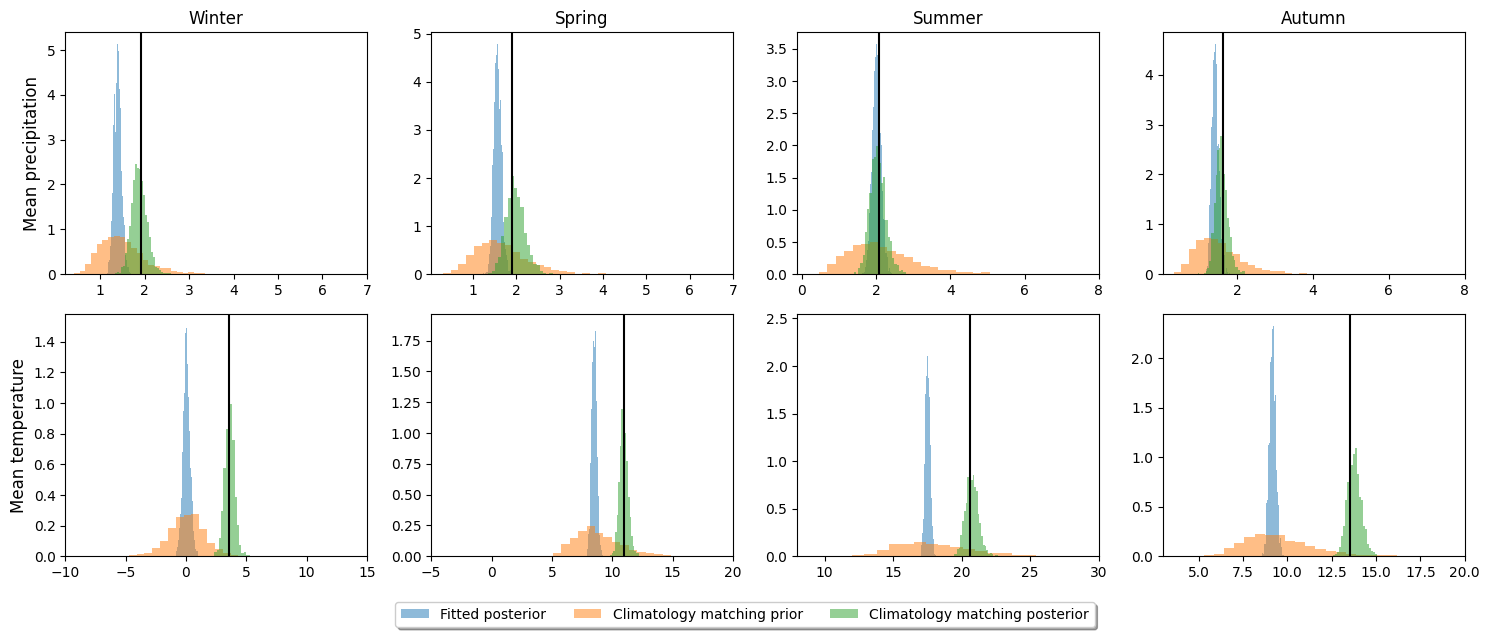

In [106]:
# Plot
idxs = [0, 1, 2, 3, 4, 5, 6, 7]

left_xlims = [None, None, None, None, -10, -5, 8, 3]
right_xlims = [7, 7, 8, 8, 15, 20, 30, 20]

samples_summary_stats_reduced_plot = dict()
samples_summary_stats_reduced_plot["fitted_posterior"] = samples_summary_stats["fitted_posterior"][:, idxs]
samples_summary_stats_reduced_plot["sbi_proposal"] = samples_summary_stats["sbi_proposal"][:, idxs]
samples_summary_stats_reduced_plot["sbi_posterior"] = samples_summary_stats["sbi_posterior"][:, idxs]
obs_stats_target_reduced_plot = obs_stats_target[idxs, :]

fig, axs = plt.subplots(2, 4, figsize = (15, 6), layout = "tight")
axs[0, 0].set_ylabel("Mean precipitation", size = "large")
axs[1, 0].set_ylabel("Mean temperature", size = "large")

axs = axs.ravel()
axs[0].set_title("Winter")
axs[1].set_title("Spring")
axs[2].set_title("Summer")
axs[3].set_title("Autumn")

for i in range(obs_stats_target_reduced_plot.shape[0]):
    axs[i].hist(samples_summary_stats_reduced_plot["fitted_posterior"][:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "Fitted posterior")
    axs[i].hist(samples_summary_stats_reduced_plot["sbi_proposal"][:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "Climatology matching prior")
    axs[i].hist(samples_summary_stats_reduced_plot["sbi_posterior"][:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "Climatology matching posterior")
    #axs[i].legend(loc = "upper right")
    #axs[i].set_title(titles[i])
    axs[i].axvline(obs_stats_target_reduced_plot[i,:].flatten(), c= "black")
    axs[i].set_xlim(left = left_xlims[i], right = right_xlims[i])
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.0),
          fancybox=True, shadow=True, ncol=5)
plt.savefig("plots/analysis_v9/case_study_3c.png", dpi = 300, bbox_inches='tight')

In [182]:
obs_hist = t2j(samples_obs["mean_fitted_posterior"])
obs_fut = t2j(samples_obs["sbi_posterior_point_estimate"])

pr_hist, tmin_hist, tavg_hist, tmax_hist = obs_hist[:, :, 0], obs_hist[:, :, 1], obs_hist[:, :, 2], obs_hist[:, :, 3]
pr_fut, tmin_fut, tavg_fut, tmax_fut = obs_fut[:, :, 0], obs_fut[:, :, 1], obs_fut[:, :, 2], obs_fut[:, :, 3]

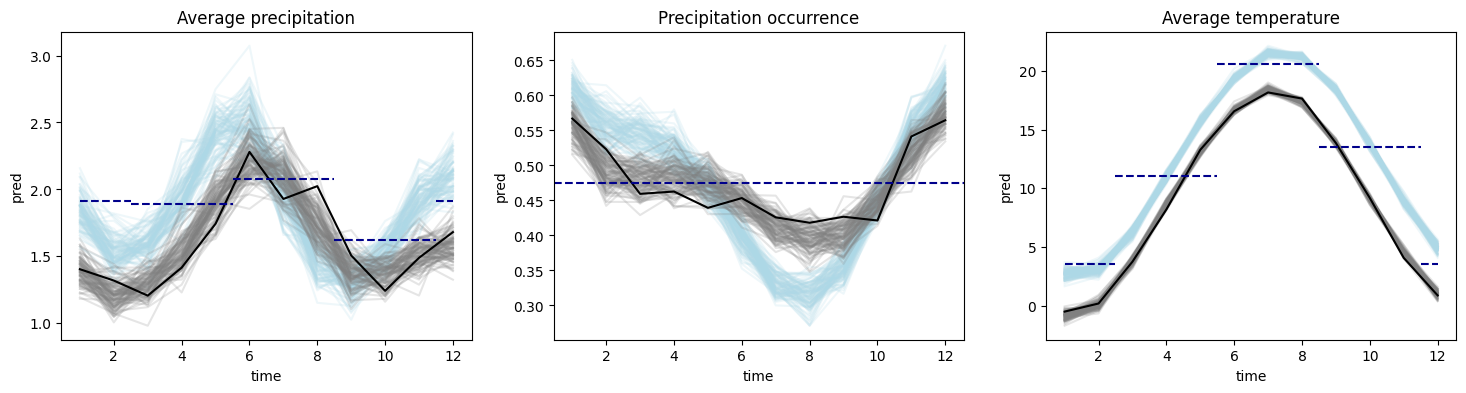

In [183]:
fig, axs = plt.subplots(1,3, figsize = (18,4))
make_line_plots(pr_fut, pr_hist, obs["prec"], basin_data_train.index, ax = axs[0])
add_seasonal_targets(obs_stats_target[:4], axs[0])
axs[0].set_title("Average precipitation")

make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, basin_data_train.index, ax = axs[1], target = obs_stats_target[9])
axs[1].set_title("Precipitation occurrence")

make_line_plots(tavg_fut, tavg_hist, obs["Tavg"], basin_data_train.index, ax = axs[2])
add_seasonal_targets(obs_stats_target[4:], axs[2])
axs[2].set_title("Average temperature")
plt.savefig("plots/analysis_v9/case_study_3c_ensemble.png")

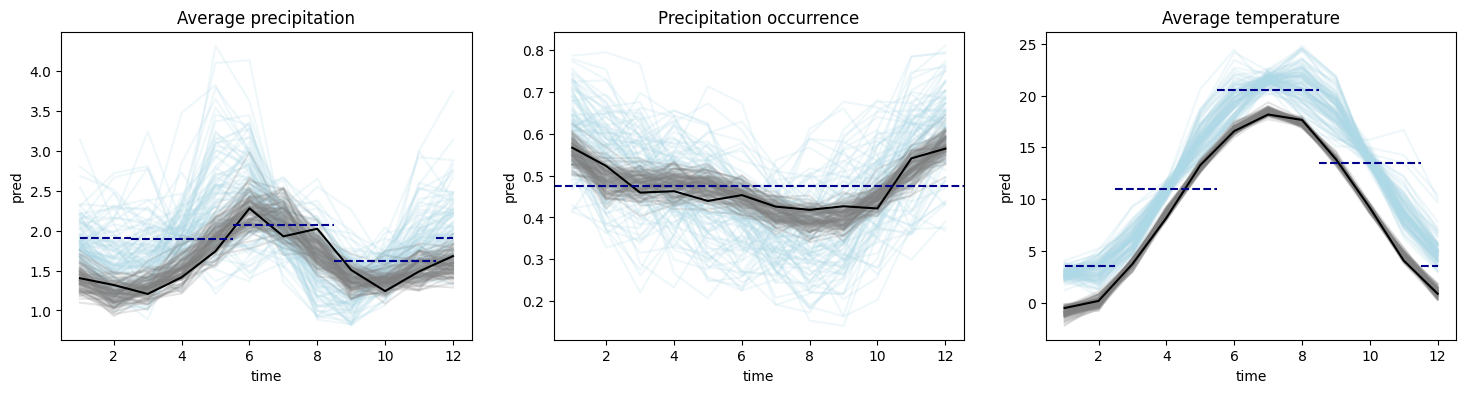

In [184]:
obs_hist = t2j(samples_obs["fitted_posterior"])
obs_fut = t2j(samples_obs["sbi_posterior"])

pr_hist, tmin_hist, tavg_hist, tmax_hist = obs_hist[:, :, 0], obs_hist[:, :, 1], obs_hist[:, :, 2], obs_hist[:, :, 3]
pr_fut, tmin_fut, tavg_fut, tmax_fut = obs_fut[:, :, 0], obs_fut[:, :, 1], obs_fut[:, :, 2], obs_fut[:, :, 3]

fig, axs = plt.subplots(1,3, figsize = (18,4))
make_line_plots(pr_fut, pr_hist, obs["prec"], basin_data_train.index, ax = axs[0])
add_seasonal_targets(obs_stats_target[:4], axs[0])
axs[0].set_title("Average precipitation")

make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, basin_data_train.index, ax = axs[1], target = obs_stats_target[9])
axs[1].set_title("Precipitation occurrence")

make_line_plots(tavg_fut, tavg_hist, obs["Tavg"], basin_data_train.index, ax = axs[2])
add_seasonal_targets(obs_stats_target[4:], axs[2])
axs[2].set_title("Average temperature")
plt.savefig("plots/analysis_v9/case_study_3c_ensemble_full_posterior.png")

### Overview part d)

In [108]:
sbi_posterior, samples_summary_stats, samples_obs = load_sbi_case_study("3d")

In [109]:
obs_stats_target = case_study_3d(jnp.expand_dims(wgen.timestamps[0,:,:], 0), obs['prec'].T, obs['Tmin'].T, obs['Tavg'].T, obs['Tmax'].T)
obs_stats_target = obs_stats_target.at[0].mul(1.3) # pmean winter
obs_stats_target = obs_stats_target.at[1].mul(1.3) # pmean spring
obs_stats_target = obs_stats_target.at[2].mul(1.) # pmean summer
obs_stats_target = obs_stats_target.at[3].mul(1.15) # pmean autumn

obs_stats_target = obs_stats_target.at[4].add(3.4) # Tavg winter
obs_stats_target = obs_stats_target.at[5].add(2.6) # Tavg spring
obs_stats_target = obs_stats_target.at[6].add(3.1) # Tavg summer
obs_stats_target = obs_stats_target.at[7].add(4.5) # Tavg autumn


In [111]:
# Plot
idxs = [0, 1, 2, 3, 4, 5, 6, 7]

left_xlims = [None, None, None, None, -10, -5, 8, 3]
right_xlims = [7, 7, 8, 8, 15, 20, 30, 20]

samples_summary_stats_reduced_plot = dict()
samples_summary_stats_reduced_plot["fitted_posterior"] = samples_summary_stats["fitted_posterior"][:, idxs]
samples_summary_stats_reduced_plot["sbi_proposal"] = samples_summary_stats["sbi_proposal"][:, idxs]
samples_summary_stats_reduced_plot["sbi_posterior"] = samples_summary_stats["sbi_posterior"][:, idxs]
obs_stats_target_reduced_plot = obs_stats_target[idxs, :]

fig, axs = plt.subplots(2, 4, figsize = (15, 6), layout = "tight")
axs[0, 0].set_ylabel("Mean precipitation", size = "large")
axs[1, 0].set_ylabel("Mean temperature", size = "large")

axs = axs.ravel()
axs[0].set_title("Winter")
axs[1].set_title("Spring")
axs[2].set_title("Summer")
axs[3].set_title("Autumn")

for i in range(obs_stats_target_reduced_plot.shape[0]):
    axs[i].hist(samples_summary_stats_reduced_plot["fitted_posterior"][:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "Calibration posterior")
    axs[i].hist(samples_summary_stats_reduced_plot["sbi_proposal"][:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "Climatology matching prior")
    axs[i].hist(samples_summary_stats_reduced_plot["sbi_posterior"][:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "Climatology matching posterior")
    #axs[i].legend(loc = "upper right")
    #axs[i].set_title(titles[i])
    axs[i].axvline(obs_stats_target_reduced_plot[i,:].flatten(), c= "black")
    axs[i].set_xlim(left = left_xlims[i], right = right_xlims[i])
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.0),
          fancybox=True, shadow=True, ncol=5)
plt.savefig("plots/analysis_v9/case_study_3d.png", dpi = 300, bbox_inches='tight')

In [189]:
obs_hist = t2j(samples_obs["mean_fitted_posterior"])
obs_fut = t2j(samples_obs["sbi_posterior_point_estimate"])

pr_hist, tmin_hist, tavg_hist, tmax_hist = obs_hist[:, :, 0], obs_hist[:, :, 1], obs_hist[:, :, 2], obs_hist[:, :, 3]
pr_fut, tmin_fut, tavg_fut, tmax_fut = obs_fut[:, :, 0], obs_fut[:, :, 1], obs_fut[:, :, 2], obs_fut[:, :, 3]

In [190]:
fig, axs = plt.subplots(1,3, figsize = (18,4))
make_line_plots(pr_fut, pr_hist, obs["prec"], basin_data_train.index, ax = axs[0])
add_seasonal_targets(obs_stats_target[:4], axs[0])
axs[0].set_title("Average precipitation")

make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, basin_data_train.index, ax = axs[1])
axs[1].set_title("Precipitation occurrence")

make_line_plots(tavg_fut, tavg_hist, obs["Tavg"], basin_data_train.index, ax = axs[2])
add_seasonal_targets(obs_stats_target[4:], axs[2])
axs[2].set_title("Average temperature")
plt.savefig("plots/analysis_v9/case_study_3d_ensemble.png")

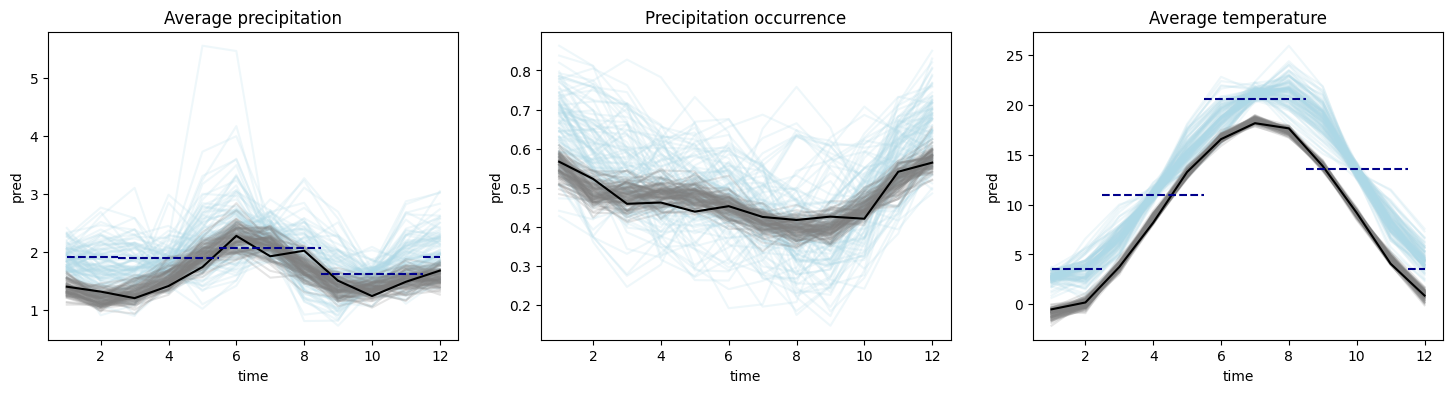

In [191]:
obs_hist = t2j(samples_obs["fitted_posterior"])
obs_fut = t2j(samples_obs["sbi_posterior"])

pr_hist, tmin_hist, tavg_hist, tmax_hist = obs_hist[:, :, 0], obs_hist[:, :, 1], obs_hist[:, :, 2], obs_hist[:, :, 3]
pr_fut, tmin_fut, tavg_fut, tmax_fut = obs_fut[:, :, 0], obs_fut[:, :, 1], obs_fut[:, :, 2], obs_fut[:, :, 3]

fig, axs = plt.subplots(1,3, figsize = (18,4))
make_line_plots(pr_fut, pr_hist, obs["prec"], basin_data_train.index, ax = axs[0])
add_seasonal_targets(obs_stats_target[:4], axs[0])
axs[0].set_title("Average precipitation")

make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, basin_data_train.index, ax = axs[1])
axs[1].set_title("Precipitation occurrence")

make_line_plots(tavg_fut, tavg_hist, obs["Tavg"], basin_data_train.index, ax = axs[2])
add_seasonal_targets(obs_stats_target[4:], axs[2])
axs[2].set_title("Average temperature")
plt.savefig("plots/analysis_v9/case_study_3d_ensemble_full_posterior.png")

### Comparison of Climatology matching posterior for occurrence

In [201]:
case_studies = ["3a", "3b", "3c", "3d"]
case_study_names = ["a)", "b)", "c)", "d)"]

fig, axs = plt.subplots(1,4, figsize = (22,4), sharey = True)

for i in range(4):

    case_study = case_studies[i]
    case_study_name = case_study_names[i]

    samples_obs = torch.load(f"sbi_results/analysis_v9/case_study_{case_study}_samples_summary_obs.pt")
    
    obs_hist = t2j(samples_obs["mean_fitted_posterior"])
    obs_fut = t2j(samples_obs["sbi_posterior_point_estimate"])
    
    pr_hist, tmin_hist, tavg_hist, tmax_hist = obs_hist[:, :, 0], obs_hist[:, :, 1], obs_hist[:, :, 2], obs_hist[:, :, 3]
    pr_fut, tmin_fut, tavg_fut, tmax_fut = obs_fut[:, :, 0], obs_fut[:, :, 1], obs_fut[:, :, 2], obs_fut[:, :, 3]

    make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, basin_data_train.index, ax = axs[i])
    axs[i].set_title(case_study_name)

    #fig.suptitle("Precipitation occurrence")

plt.savefig("plots/analysis_v9/case_study_3_occ_comparison.png")

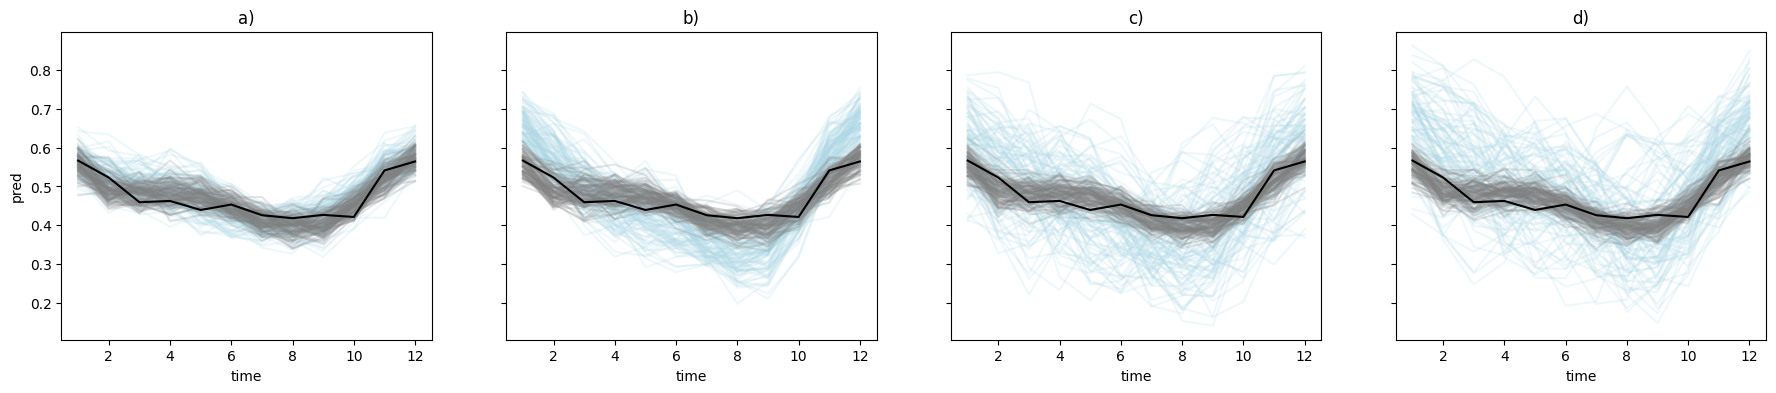

In [203]:
case_studies = ["3a", "3b", "3c", "3d"]
case_study_names = ["a)", "b)", "c)", "d)"]

fig, axs = plt.subplots(1,4, figsize = (22,4), sharey = True)

for i in range(4):

    case_study = case_studies[i]
    case_study_name = case_study_names[i]

    samples_obs = torch.load(f"sbi_results/analysis_v9/case_study_{case_study}_samples_summary_obs.pt")
    
    obs_hist = t2j(samples_obs["fitted_posterior"])
    obs_fut = t2j(samples_obs["sbi_posterior"])
    
    pr_hist, tmin_hist, tavg_hist, tmax_hist = obs_hist[:, :, 0], obs_hist[:, :, 1], obs_hist[:, :, 2], obs_hist[:, :, 3]
    pr_fut, tmin_fut, tavg_fut, tmax_fut = obs_fut[:, :, 0], obs_fut[:, :, 1], obs_fut[:, :, 2], obs_fut[:, :, 3]

    make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, basin_data_train.index, ax = axs[i])
    axs[i].set_title(case_study_name)

    #fig.suptitle("Precipitation occurrence")

plt.savefig("plots/analysis_v9/case_study_3_occ_comparison_full_posterior.png")